## Маркенговый анализ приложения Procrastinate Pro+

### Описание проекта

Необходимо понять, почему развлекательное приложение Procrastinate Pro+., несмотря на огромные вложения в рекламу, последние несколько месяцев компания терпит убытки. Наша задача — разобраться в причинах и помочь компании выйти в плюс.

Нам предоставили данные о пользователях, привлечённых с 1 мая по 27 октября 2019 года:
- лог сервера с данными об их посещениях,
- выгрузка их покупок за этот период,
- рекламные расходы.

Исследование будет состоять из следующих разделов:

1) [Изучение и предоработка данных,](#explore) где мы изучим наши данные и при необходимости предоработаем;

2) [Исследование данных](#research_data), где мы поймем, из каких стран наши пользователи, с каких устройств и из каких источников они приходят в изучаемое приложение;

3) [Исследование продукта](#research_product), где мы рассчитаем DAU/WAU/MAU и узнаем, сколько в среднем сессий происходит в приложении в день, и сколько в среднем пользователи проводят времени в приложении;

4) [Исследование продаж](#research_sellout) - здесь мы сколько времени нужно пользователю, чтобы принять решение о покупке в приложении, какой средний чек и сколько покупок в день/неделю/месяц совершает пользователь в среднем;

5) [Исследование маркетинга](#research_marketing) - исследуем все основные маркетинговые метрики (LTV, ROI, CAC, удержание и конверсию по всем параметрам) и будем искать причины убыточности приложения;

6) [Общие выводы](#conclus), где в кратце изложу все промежуточные детали и дам рекомендации по развитию приложения.


### Описание данных

В нашем распоряжении три датасета. Файл visits_info_short.csv хранит лог сервера с информацией о посещениях сайта, orders_info_short.csv — информацию о покупках, а costs_info_short.csv — информацию о расходах на рекламу.


In [1]:
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')


### Изучение и предоработка данных <a id='explore'></a>

Загрузим предоставленные нам таблицы:

In [2]:
try:
    visits = pd.read_csv('visits_info_short.csv')
    orders = pd.read_csv('orders_info_short.csv')
    costs = pd.read_csv('costs_info_short.csv')
except:
    visits = pd.read_csv('/datasets/visits_info_short.csv')
    orders = pd.read_csv('/datasets/orders_info_short.csv')
    costs = pd.read_csv('/datasets/costs_info_short.csv')

Создадим функцию для описания таблицы, которая покажет общую информацию о таблице, долю пропусков, количество дублей и статистическое описание данных:

In [3]:
def df_describer(df):
    '''
    Функция для описания таблицы. Выдает:
    - общую информацию о таблице;
    - количество пропусков;
    - количество дубликатов;
    - описание данных.
    Принимает в качестве аргумента переменную с датафреймом.
    '''
    print('Общая информация о таблице: ')
    print(df.info())
    print('=============')
    print('Пропуски в данных: ')
    display(
        df.isna().mean().to_frame('Nan')
        .join(df.isna().mean().to_frame('Nan, %'))
        .style.format({'Nan, %': '{:,.1%}'.format})
    )
    print('=============')
    print('Количество дублей: ')
    print(df.duplicated().sum())
    print('=============')
    print('Описание данных')
    display(df.describe(include='all'))


Сначала посмотрим, какими данными мы располагает в каждой таблице по отдельности. Начнем с визитов.

In [4]:
df_describer(visits)

Общая информация о таблице: 
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 309901 entries, 0 to 309900
Data columns (total 6 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   User Id        309901 non-null  int64 
 1   Region         309901 non-null  object
 2   Device         309901 non-null  object
 3   Channel        309901 non-null  object
 4   Session Start  309901 non-null  object
 5   Session End    309901 non-null  object
dtypes: int64(1), object(5)
memory usage: 14.2+ MB
None
Пропуски в данных: 


,Nan,"Nan, %"
User Id,0.000000,0.0%
Region,0.000000,0.0%
Device,0.000000,0.0%
Channel,0.000000,0.0%
Session Start,0.000000,0.0%
Session End,0.000000,0.0%


Количество дублей: 
0
Описание данных


,User Id,Region,Device,Channel,Session Start,Session End
count,3.099010e+05,309901,309901,309901,309901,309901
unique,NaN,4,4,11,306813,306793
top,NaN,United States,iPhone,organic,2019-10-02 09:50:32,2019-07-29 11:21:53
freq,NaN,207327,112603,107760,3,3
mean,4.997664e+11,NaN,NaN,NaN,NaN,NaN
std,2.887899e+11,NaN,NaN,NaN,NaN,NaN
min,5.993260e+05,NaN,NaN,NaN,NaN,NaN
25%,2.493691e+11,NaN,NaN,NaN,NaN,NaN
50%,4.989906e+11,NaN,NaN,NaN,NaN,NaN
75%,7.495211e+11,NaN,NaN,NaN,NaN,NaN


Структура visits_info_short.csv
- User Id — уникальный идентификатор пользователя,
- Region — страна пользователя,
- Device — тип устройства пользователя,
- Channel — идентификатор источника перехода,
- Session Start — дата и время начала сессии,
- Session End — дата и время окончания сессии.

В данных с визитами нет пропусков и дубликатов. По поводу дубликатов, думаю, можно поверить, так как считаю, что у пользователей номра индивидуальные и они не должны переприсваиваться при повторном визите, а из колонки user_id мы видим, что в таблице они не имеют повторений. Еще это значит, что в промежуток времени, за который нам предоставили данные, каждый пользователь заходил в приложение только 1 раз.

Также предварительно можно сказать, что большинство наших пользователей из США, пришли к нам напрямую (органический тип, то есть условно бесплатные пользователи) и с устройств IPhone.

Столбцы session_start и session_end нужно перевести в формат datetime для дальней работы с данными.

Далее - заказы:

In [5]:
df_describer(orders)

Общая информация о таблице: 
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40212 entries, 0 to 40211
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   User Id   40212 non-null  int64  
 1   Event Dt  40212 non-null  object 
 2   Revenue   40212 non-null  float64
dtypes: float64(1), int64(1), object(1)
memory usage: 942.6+ KB
None
Пропуски в данных: 


,Nan,"Nan, %"
User Id,0.000000,0.0%
Event Dt,0.000000,0.0%
Revenue,0.000000,0.0%


Количество дублей: 
0
Описание данных


,User Id,Event Dt,Revenue
count,4.021200e+04,40212,40212.000000
unique,NaN,40163,NaN
top,NaN,2019-09-14 23:35:11,NaN
freq,NaN,2,NaN
mean,4.990295e+11,NaN,5.370608
std,2.860937e+11,NaN,3.454208
min,5.993260e+05,NaN,4.990000
25%,2.511324e+11,NaN,4.990000
50%,4.982840e+11,NaN,4.990000
75%,7.433327e+11,NaN,4.990000


Структура orders_info_short.csv
- User Id — уникальный идентификатор пользователя,
- Event Dt — дата и время покупки,
- Revenue — сумма заказа.

Тоже нет пропусков и дубликатов в данных и тип колонки Event Dt нужно перевести в datetime.

Сделаем предварительный вывод, что большинство заказов у нас на 4.99 уе, но есть небольшое число крупных заказов, которые сбивают среднее до 5.37 уе.

И таблица со стоимостью рекламы:

In [6]:
df_describer(costs)

Общая информация о таблице: 
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1800 entries, 0 to 1799
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   dt       1800 non-null   object 
 1   Channel  1800 non-null   object 
 2   costs    1800 non-null   float64
dtypes: float64(1), object(2)
memory usage: 42.3+ KB
None
Пропуски в данных: 


,Nan,"Nan, %"
dt,0.000000,0.0%
Channel,0.000000,0.0%
costs,0.000000,0.0%


Количество дублей: 
0
Описание данных


,dt,Channel,costs
count,1800,1800,1800.000000
unique,180,10,NaN
top,2019-08-09,TipTop,NaN
freq,10,180,NaN
mean,NaN,NaN,58.609611
std,NaN,NaN,107.740223
min,NaN,NaN,0.800000
25%,NaN,NaN,6.495000
50%,NaN,NaN,12.285000
75%,NaN,NaN,33.600000


Структура costs_info_short.csv
- Channel — идентификатор рекламного источника,
- Dt — дата проведения рекламной кампании,
- Costs — расходы на эту кампанию.

Таблица без пропусков и дублей, колонку dt переведем в datetime.

У нас 10 рекламных каналов. По стоимости пока можно сказать, что сильно различаются медиана со средней (медиана меньше почти в 5 раз), что говорит нам о каких-то очень дорогостоящих рекламных кампаниях.

Приступаем к обработке таблиц.

Прежде всего приведем названия колонок в привычную форму - нижний регистр и змеиный тип:

In [7]:
for df in [visits, orders, costs]:
    df.columns = list(map(lambda x: x.lower().replace(' ', '_'), df.columns))
    print(df.columns)

Index(['user_id', 'region', 'device', 'channel', 'session_start',
       'session_end'],
      dtype='object')
Index(['user_id', 'event_dt', 'revenue'], dtype='object')
Index(['dt', 'channel', 'costs'], dtype='object')


Теперь переведем колонки с временными характеристиками в тип datetime:

In [8]:
# метод to_datetime(), конечно. Пока не будем выделять какие-то отдельные части из времени.

visits['session_start'] = pd.to_datetime(visits['session_start'])
visits['session_end'] = pd.to_datetime(visits['session_end'])

orders['event_dt'] = pd.to_datetime(orders['event_dt'])

# Здесь выделим только дату, без времени, это пригодится в дальнейшем
costs['dt'] = pd.to_datetime(costs['dt']).dt.date

# И так как я не доверяю себе, проверим, все ли правильно сработало:

df_describer(visits)
df_describer(orders)
df_describer(costs)

Общая информация о таблице: 
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 309901 entries, 0 to 309900
Data columns (total 6 columns):
 #   Column         Non-Null Count   Dtype         
---  ------         --------------   -----         
 0   user_id        309901 non-null  int64         
 1   region         309901 non-null  object        
 2   device         309901 non-null  object        
 3   channel        309901 non-null  object        
 4   session_start  309901 non-null  datetime64[ns]
 5   session_end    309901 non-null  datetime64[ns]
dtypes: datetime64[ns](2), int64(1), object(3)
memory usage: 14.2+ MB
None
Пропуски в данных: 


,Nan,"Nan, %"
user_id,0.000000,0.0%
region,0.000000,0.0%
device,0.000000,0.0%
channel,0.000000,0.0%
session_start,0.000000,0.0%
session_end,0.000000,0.0%


Количество дублей: 
0
Описание данных


,user_id,region,device,channel,session_start,session_end
count,3.099010e+05,309901,309901,309901,309901,309901
unique,NaN,4,4,11,306813,306793
top,NaN,United States,iPhone,organic,2019-06-27 14:56:41,2019-08-04 10:32:15
freq,NaN,207327,112603,107760,3,3
first,NaN,NaN,NaN,NaN,2019-05-01 00:00:41,2019-05-01 00:07:06
last,NaN,NaN,NaN,NaN,2019-10-31 23:59:23,2019-11-01 01:38:46
mean,4.997664e+11,NaN,NaN,NaN,NaN,NaN
std,2.887899e+11,NaN,NaN,NaN,NaN,NaN
min,5.993260e+05,NaN,NaN,NaN,NaN,NaN
25%,2.493691e+11,NaN,NaN,NaN,NaN,NaN


Общая информация о таблице: 
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40212 entries, 0 to 40211
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   user_id   40212 non-null  int64         
 1   event_dt  40212 non-null  datetime64[ns]
 2   revenue   40212 non-null  float64       
dtypes: datetime64[ns](1), float64(1), int64(1)
memory usage: 942.6 KB
None
Пропуски в данных: 


,Nan,"Nan, %"
user_id,0.000000,0.0%
event_dt,0.000000,0.0%
revenue,0.000000,0.0%


Количество дублей: 
0
Описание данных


,user_id,event_dt,revenue
count,4.021200e+04,40212,40212.000000
unique,NaN,40163,NaN
top,NaN,2019-09-29 09:03:24,NaN
freq,NaN,2,NaN
first,NaN,2019-05-01 00:28:11,NaN
last,NaN,2019-10-31 23:56:56,NaN
mean,4.990295e+11,NaN,5.370608
std,2.860937e+11,NaN,3.454208
min,5.993260e+05,NaN,4.990000
25%,2.511324e+11,NaN,4.990000


Общая информация о таблице: 
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1800 entries, 0 to 1799
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   dt       1800 non-null   object 
 1   channel  1800 non-null   object 
 2   costs    1800 non-null   float64
dtypes: float64(1), object(2)
memory usage: 42.3+ KB
None
Пропуски в данных: 


,Nan,"Nan, %"
dt,0.000000,0.0%
channel,0.000000,0.0%
costs,0.000000,0.0%


Количество дублей: 
0
Описание данных


,dt,channel,costs
count,1800,1800,1800.000000
unique,180,10,NaN
top,2019-06-07,TipTop,NaN
freq,10,180,NaN
mean,NaN,NaN,58.609611
std,NaN,NaN,107.740223
min,NaN,NaN,0.800000
25%,NaN,NaN,6.495000
50%,NaN,NaN,12.285000
75%,NaN,NaN,33.600000


Все получилось, теперь видим, что диапазон дат охвата у нас с 1 мая 2019 года по 31 октября 2019 (Заказы), а последняя дата окончания сессии 1 ноября.

### Исследование данных <a id='research_data'></a>

Приступаем к исследованию данных. 

Для этого сначала определим необходиме для нас функции: 
- get_profiles() - создает таблицу с профилями пользователей (их характеристики), 
- get_retention() - таблицы удержания и динамики удержания пользователей, 
- get_conversion() - таблицы коверсии и динамики конверсии пользователей, 
- get_ltv_roi() - таблицы LTV и ROI, а так же их динамика

In [9]:
def get_profiles(sessions, orders, ad_costs, events=None, event_names=[]):
    '''
    Функция для создания пользовательских профилей.
    Аргументы:
    - таблица сессий;
    - таблица заказов;
    - таблица стоимости рекламы,
    - таблица событий (по умолчанию ее нет);
    - список интересуемых событий (по умолчания пустой список)
    '''
    # Создаем таблицу профилей, где находим первые посещения для всех пользователей (дату, канал, устройство, регион первого входа)

    # сортируем сессии по ID пользователя и дате привлечения
    # группируем по ID и находим параметры первых посещений
    profiles = (
        sessions.sort_values(by=['user_id', 'session_start'])
        .groupby('user_id')
        .agg(
            {
                'session_start': 'first',
                'channel': 'first',
                'device': 'first',
                'region': 'first',
            }
        )
         # время первого посещения назовём first_ts
        .rename(columns={'session_start': 'first_ts'})
        .reset_index()  # возвращаем user_id из индекса
    )

    # для когортного анализа определяем дату первого посещения
    # и первый день месяца, в который это посещение произошло
    profiles['dt'] = profiles['first_ts'].dt.date
    profiles['month'] = profiles['first_ts'].astype('datetime64[M]')

    # добавляем признак платящих пользователей 
    # (если пользователь встречается в таблице заказов, он платящий - True, иначе - False)
    profiles['payer'] = profiles['user_id'].isin(orders['user_id'].unique())

    # добавляем флаги для всех событий из event_names 
    # (если пользователь участвовал в событии, то в столбце события повится True, не участвова - False)
    for event in event_names:
        if event in events['event_name'].unique():
            # проверяем, встречается ли каждый пользователь
            # среди тех, кто совершил событие event
            profiles[event] = profiles['user_id'].isin(
                events.query('event_name == @event')['user_id'].unique()
            )

    # считаем количество уникальных пользователей
    # с одинаковыми источником и датой привлечения
    new_users = (
        profiles.groupby(['dt', 'channel'])
        .agg({'user_id': 'nunique'})
         # столбец с числом пользователей назовём unique_users
        .rename(columns={'user_id': 'unique_users'})
        .reset_index()  # возвращаем dt и channel из индексов
    )

    # объединяем траты на рекламу и число привлечённых пользователей
    # по дате и каналу привлечения
    ad_costs = ad_costs.merge(new_users, on=['dt', 'channel'], how='left')

    # делим рекламные расходы на число привлечённых пользователей
    # результаты сохраним в столбец acquisition_cost (CAC)
    ad_costs['acquisition_cost'] = ad_costs['costs'] / ad_costs['unique_users']

    # добавим стоимость привлечения в профили
    profiles = profiles.merge(
        ad_costs[['dt', 'channel', 'acquisition_cost']],
        on=['dt', 'channel'],
        how='left',
    )

    # органические пользователи не связаны с данными о рекламе,
    # поэтому в столбце acquisition_cost у них значения NaN
    # заменим их на ноль, ведь стоимость привлечения равна нулю
    profiles['acquisition_cost'] = profiles['acquisition_cost'].fillna(0)
    
    return profiles  # возвращаем профили с CAC

In [10]:
# Функция удержания:
def get_retention(
    profiles,
    sessions,
    observation_date,
    horizon_days,
    dimensions=[],
    ignore_horizon=False,
):
    '''
     Аргументы:
     - таблица с профилями;
     - таблица с сессиями (идентификатор пользователя, дата начала действия, длительность сессии и тд)
     - момент анализа - куда смотрим;
     - горизонт анализа  - максимальное количество дней жизненного цикла клиента (лайфтайма);
     - dimensions=[] - принимает список столбцов, по которым будут группироваться данные для когорты;
     - ignore_horizon=False - параметр для исключения когорт с пользователями без данных в течение горизонта событий.
     Функция вовращает таблицу удержания, таблицу динамики удержания и сырые данные
    '''

    # добавляем столбец payer в передаваемый dimensions список
    dimensions = ['payer'] + dimensions

    # исключаем пользователей, не «доживших» до горизонта анализа
    last_suitable_acquisition_date = observation_date
    if not ignore_horizon:
        last_suitable_acquisition_date = observation_date - timedelta(
            days=horizon_days - 1
        )
    result_raw = profiles.query('dt <= @last_suitable_acquisition_date')

    # собираем «сырые» данные для расчёта удержания
    result_raw = result_raw.merge(
        sessions[['user_id', 'session_start']], on='user_id', how='left'
    )
    result_raw['lifetime'] = (
        result_raw['session_start'] - result_raw['first_ts']
    ).dt.days

    # функция для группировки таблицы по желаемым признакам
    def group_by_dimensions(df, dims, horizon_days):
        result = df.pivot_table(
            index=dims, columns='lifetime', values='user_id', aggfunc='nunique'
        )
        cohort_sizes = (
            df.groupby(dims)
            .agg({'user_id': 'nunique'})
            .rename(columns={'user_id': 'cohort_size'})
        )
        result = cohort_sizes.merge(result, on=dims, how='left').fillna(0)
        result = result.div(result['cohort_size'], axis=0)
        result = result[['cohort_size'] + list(range(horizon_days))]
        result['cohort_size'] = cohort_sizes
        return result

    # получаем таблицу удержания
    result_grouped = group_by_dimensions(result_raw, dimensions, horizon_days)

    # получаем таблицу динамики удержания, в которой добавляем временной признак
    result_in_time = group_by_dimensions(
        result_raw, dimensions + ['dt'], horizon_days
    )

    # возвращаем обе таблицы и сырые данные
    return result_raw, result_grouped, result_in_time

In [11]:
# Функция коверсии:
def get_conversion(
    profiles,
    purchases,
    observation_date,
    horizon_days,
    dimensions=[],
    ignore_horizon=False,
):
    '''
    Аргументы функции для расчета конверсии:
    - таблица с профилями;
     - таблица с заказами;
     - момент анализа;
     - горизонт анализа  - максимальное количество дней жизненного цикла клиента (лайфтайма);
     - dimensions=[] - принимает список столбцов, по которым будут группироваться данные для когорты;
     - ignore_horizon=False - параметр для исключения когорт с пользователями без данных в течение горизонта событий.
     Функция вовращает таблицу корверсии, таблицу динамики конверсии и сырые данные
    '''

    # исключаем пользователей, не «доживших» до горизонта анализа
    last_suitable_acquisition_date = observation_date
    if not ignore_horizon:
        last_suitable_acquisition_date = observation_date - timedelta(
            days=horizon_days - 1
        )
    result_raw = profiles.query('dt <= @last_suitable_acquisition_date')

    # определяем дату и время первой покупки для каждого пользователя
    first_purchases = (
        purchases.sort_values(by=['user_id', 'event_dt'])
        .groupby('user_id')
        .agg({'event_dt': 'first'})
        .reset_index()
    )

    # добавляем данные о покупках в профили
    result_raw = result_raw.merge(
        first_purchases[['user_id', 'event_dt']], on='user_id', how='left'
    )

    # рассчитываем лайфтайм для каждой покупки
    result_raw['lifetime'] = (
        result_raw['event_dt'] - result_raw['first_ts']
    ).dt.days

    # группируем по cohort, если в dimensions ничего нет
    if len(dimensions) == 0:
        result_raw['cohort'] = 'All users'
        dimensions = dimensions + ['cohort']

    # функция для группировки таблицы по желаемым признакам
    def group_by_dimensions(df, dims, horizon_days):
        # строим «треугольную» таблицу конверсии
        result = df.pivot_table(
            index=dims, columns='lifetime', values='user_id', aggfunc='nunique'
        )
        # считаем сумму с накоплением для каждой строки
        result = result.fillna(0).cumsum(axis = 1)
        # вычисляем размеры когорт
        cohort_sizes = (
            df.groupby(dims)
            .agg({'user_id': 'nunique'})
            .rename(columns={'user_id': 'cohort_size'})
        )
        # добавляем размеры когорт в таблицу конверсии
        result = cohort_sizes.merge(result, on=dims, how='left').fillna(0)
        # делим каждую «ячейку» в строке на размер когорты
        # и получаем conversion rate
        result = result.div(result['cohort_size'], axis=0)
        # исключаем все лайфтаймы, превышающие горизонт анализа
        result = result[['cohort_size'] + list(range(horizon_days))]
        # восстанавливаем размеры когорт
        result['cohort_size'] = cohort_sizes
        return result

    # получаем таблицу конверсии
    result_grouped = group_by_dimensions(result_raw, dimensions, horizon_days)

    # для таблицы динамики конверсии убираем 'cohort' из dimensions
    if 'cohort' in dimensions: 
        dimensions = []

    # получаем таблицу динамики конверсии
    result_in_time = group_by_dimensions(
        result_raw, dimensions + ['dt'], horizon_days
    )

    # возвращаем обе таблицы и сырые данные
    return result_raw, result_grouped, result_in_time

In [12]:
# Функция для расчета LTV/ROI:
def get_ltv_roi(
    profiles,
    purchases,
    observation_date,
    horizon_days,
    dimensions=[],
    ignore_horizon=False,
):
    '''
    Аргументы функции для расчета LTV/ROI:
    - таблица профилей пользователя;
    - таблица с заказами;
    - момент анализа;
    - горизонт анализа;
    - доп.параметры для анализа (по умолчанию пустой список);
    - ignore_horizon=False - параметр для исключения когорт с пользователями без данных в течение горизонта событий.
    Возвращает сырые данные, таблицу с LTV, динамику LTV, таблицу с ROI, динамику ROI
    '''

    # исключаем пользователей, не «доживших» до горизонта анализа
    last_suitable_acquisition_date = observation_date
    if not ignore_horizon:
        last_suitable_acquisition_date = observation_date - timedelta(
            days=horizon_days - 1
        )
    result_raw = profiles.query('dt <= @last_suitable_acquisition_date')
    # добавляем данные о покупках в профили
    result_raw = result_raw.merge(
        purchases[['user_id', 'event_dt', 'revenue']], on='user_id', how='left'
    )
    # рассчитываем лайфтайм пользователя для каждой покупки
    result_raw['lifetime'] = (
        result_raw['event_dt'] - result_raw['first_ts']
    ).dt.days
    # группируем по cohort, если в dimensions ничего нет
    if len(dimensions) == 0:
        result_raw['cohort'] = 'All users'
        dimensions = dimensions + ['cohort']

    # функция группировки по желаемым признакам
    def group_by_dimensions(df, dims, horizon_days):
        # строим «треугольную» таблицу выручки
        result = df.pivot_table(
            index=dims, columns='lifetime', values='revenue', aggfunc='sum'
        )
        # находим сумму выручки с накоплением
        result = result.fillna(0).cumsum(axis=1)
        # вычисляем размеры когорт
        cohort_sizes = (
            df.groupby(dims)
            .agg({'user_id': 'nunique'})
            .rename(columns={'user_id': 'cohort_size'})
        )
        # объединяем размеры когорт и таблицу выручки
        result = cohort_sizes.merge(result, on=dims, how='left').fillna(0)
        # считаем LTV: делим каждую «ячейку» в строке на размер когорты
        result = result.div(result['cohort_size'], axis=0)
        # исключаем все лайфтаймы, превышающие горизонт анализа
        result = result[['cohort_size'] + list(range(horizon_days))]
        # восстанавливаем размеры когорт
        result['cohort_size'] = cohort_sizes

        # сохраняем в датафрейм данные пользователей и значения CAC, 
        # добавив параметры из dimensions
        cac = df[['user_id', 'acquisition_cost'] + dims].drop_duplicates()

        # считаем средний CAC по параметрам из dimensions
        cac = (
            cac.groupby(dims)
            .agg({'acquisition_cost': 'mean'})
            .rename(columns={'acquisition_cost': 'cac'})
        )

        # считаем ROI: делим LTV на CAC
        roi = result.div(cac['cac'], axis=0)

        # удаляем строки с бесконечным ROI
        roi = roi[~roi['cohort_size'].isin([np.inf])]

        # восстанавливаем размеры когорт в таблице ROI
        roi['cohort_size'] = cohort_sizes

        # добавляем CAC в таблицу ROI
        roi['cac'] = cac['cac']

        # в финальной таблице оставляем размеры когорт, CAC
        # и ROI в лайфтаймы, не превышающие горизонт анализа
        roi = roi[['cohort_size', 'cac'] + list(range(horizon_days))]

        # возвращаем таблицы LTV и ROI
        return result, roi

    # получаем таблицы LTV и ROI
    result_grouped, roi_grouped = group_by_dimensions(
        result_raw, dimensions, horizon_days
    )

    # для таблиц динамики убираем 'cohort' из dimensions
    if 'cohort' in dimensions:
        dimensions = []

    # получаем таблицы динамики LTV и ROI
    result_in_time, roi_in_time = group_by_dimensions(
        result_raw, dimensions + ['dt'], horizon_days
    )

    return (
        result_raw,  # сырые данные
        result_grouped,  # таблица LTV
        result_in_time,  # таблица динамики LTV
        roi_grouped,  # таблица ROI
        roi_in_time,  # таблица динамики ROI
    )

Для начала создадим таблицу с профилями пользователя. Для этого нам понадобятся таблицы с визитами, с заказами и стоимостью рекламы:

In [13]:
# Применяем функцию get_profiles() и сохраняем таблицу в переменную:

profiles = get_profiles(visits, orders, costs)
profiles.head(10)

,user_id,first_ts,channel,device,region,dt,month,payer,acquisition_cost
0,599326,2019-05-07 20:58:57,FaceBoom,Mac,United States,2019-05-07,2019-05-01,True,1.088172
1,4919697,2019-07-09 12:46:07,FaceBoom,iPhone,United States,2019-07-09,2019-07-01,False,1.107237
2,6085896,2019-10-01 09:58:33,organic,iPhone,France,2019-10-01,2019-10-01,False,0.000000
3,22593348,2019-08-22 21:35:48,AdNonSense,PC,Germany,2019-08-22,2019-08-01,False,0.988235
4,31989216,2019-10-02 00:07:44,YRabbit,iPhone,United States,2019-10-02,2019-10-01,False,0.230769
5,34186288,2019-05-09 17:29:23,organic,Android,United States,2019-05-09,2019-05-01,False,0.000000
6,38448301,2019-08-16 11:56:00,organic,Android,United States,2019-08-16,2019-08-01,False,0.000000
7,46006712,2019-06-30 03:46:29,AdNonSense,Android,France,2019-06-30,2019-06-01,True,1.008000
8,58263264,2019-05-11 19:18:43,FaceBoom,iPhone,United States,2019-05-11,2019-05-01,False,1.128205
9,59835779,2019-05-11 21:13:47,MediaTornado,iPhone,United States,2019-05-11,2019-05-01,False,0.250435


Определим минимальную и максимальную даты привлечения пользователей:

In [14]:
# интервал привлечения пользователей
min_analysis_date = profiles['first_ts'].min()
observation_date = profiles['first_ts'].max()

print(f'Минимальная дата: {min_analysis_date},\nМаксимальная дата: {observation_date}')

Минимальная дата: 2019-05-01 00:00:41,
Максимальная дата: 2019-10-27 23:59:04


Выясним, из каких стран пользователи приходят в приложение и на какую страну приходится больше всего платящих пользователей. Построим таблицу, отражающую количество пользователей и долю платящих из каждой страны.

Это можно сделать, сгруппировав пользователей по странам и посчитать по столбцу payer общее количество с помощью count, количество платящих с помощью sum и долю с помощью mean, так как в данном столбце булевые значения. Так как в дальнейшем нам надо будет еще выяснить аналогичную информацию для устройств и каналов, облечем агрегацию в функцию:

In [15]:
def agg_func_profiles(column):
    '''
    Агрегирующая функция для таблицы profiles. Агрегирует по колонке в аргументе (стоковый тип).
    Считает общее количество пользователей, количество платящих пользователей и их долю.
    '''
    return profiles.groupby(column).agg(
         total = ('payer', 'count'), 
         paying_num = ('payer', 'sum'), 
         paying_rate = ('payer', 'mean')).sort_values(by=['total', 'paying_rate'], ascending=False)

agg_func_profiles('region')

,total,paying_num,paying_rate
region,,,
United States,100002,6902,0.069019
UK,17575,700,0.039829
France,17450,663,0.037994
Germany,14981,616,0.041119


Больше всего пользователей из США (как я ранее уже предполагала), у них же самая большая доля - 7%. Остальные страны сильно отстают по количеству и их доля 4%. Великобритания и Франция меньше 18 000 пользователей, в Германии - менее 15 000.

Узнайте, какими устройствами пользуются клиенты и какие устройства предпочитают платящие пользователи. Постройте таблицу, отражающую количество пользователей и долю платящих для каждого устройства.

In [16]:
agg_func_profiles('device')

,total,paying_num,paying_rate
device,,,
iPhone,54479,3382,0.062079
Android,35032,2050,0.058518
PC,30455,1537,0.050468
Mac,30042,1912,0.063644


Больше всего пользователей IPhone, затем заметно отстает Android. Пользователей PC и Mac примерно поровну, при этом наименьшая доля заплативших пользователей у PC - 5%. У остальных доля одинаковая - 6%.

Изучим теперь рекламные источники привлечения и определим каналы, из которых пришло больше всего платящих пользователей. Постройте таблицу, отражающую количество пользователей и долю платящих для каждого канала привлечения.


In [17]:
agg_func_profiles('channel')

,total,paying_num,paying_rate
channel,,,
organic,56439,1160,0.020553
FaceBoom,29144,3557,0.122049
TipTop,19561,1878,0.096007
OppleCreativeMedia,8605,233,0.027077
WahooNetBanner,8553,453,0.052964
LeapBob,8553,262,0.030633
RocketSuperAds,4448,352,0.079137
MediaTornado,4364,156,0.035747
YRabbit,4312,165,0.038265


Ниже агрегация без органики. 

In [18]:
(
    profiles[profiles['channel'] != 'organic'].groupby('channel').agg(
         total = ('payer', 'count'), 
         paying_num = ('payer', 'sum'), 
         paying_rate = ('payer', 'mean')).sort_values(by=['total', 'paying_rate'], ascending=False)
)

,total,paying_num,paying_rate
channel,,,
FaceBoom,29144,3557,0.122049
TipTop,19561,1878,0.096007
OppleCreativeMedia,8605,233,0.027077
WahooNetBanner,8553,453,0.052964
LeapBob,8553,262,0.030633
RocketSuperAds,4448,352,0.079137
MediaTornado,4364,156,0.035747
YRabbit,4312,165,0.038265
AdNonSense,3880,440,0.113402


Картина следующая - больше всего пользователей приходит в приложение органическим путем, среди них только 2% платящих, но они бесплатные. Среди рекламных источников в лидерах FaceBoom, по нему перешно 29 000 пользователей, 12% из которых стали плательнищиками. Среди удачных рекламных источнкиво по доле можно назвать TipTop, так же неплохи по доле AdNonSense и lambdaMediaAds, но они мало привлекают пользователей. Самый неудачный источник - OppleCreativeMedia, из 8 600 пользователей привлекшихся зрителей плательщиков всего 3%.

Подведем промежуточный итог:
- В основном наши пользователи из США, доля плательщиков среди них максимальная - 7%;
- Чаще всего у нас пользователи заходят с IPhone, но доля плательщиков для них такая же как и у Android, Mac, а вот платящих пользователей PC на 1% меньше.
- Больше всего пользователей приходит органическим путем. Самый успешный по доле рекламный источник - FaceBoom, самй не успешный - OppleCreativeMedia.

Но картина может поменяться, когда мы поймем, сколько стоит каждый из привлеченных рекламой пользователей.

### Исследование продукта <a id='research_product'></a>

Выясним, сколько людей пользуются приложением в день, неделю и месяц: рассчитайте DAU, WAU и MAU. 

Создадим необходимые столбцы для расчета метрик:

In [19]:
visits['date'] = visits['session_start'].dt.date
visits['week'] = visits['session_start'].dt.week
visits['month'] = visits['session_start'].dt.month

visits.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 309901 entries, 0 to 309900
Data columns (total 9 columns):
 #   Column         Non-Null Count   Dtype         
---  ------         --------------   -----         
 0   user_id        309901 non-null  int64         
 1   region         309901 non-null  object        
 2   device         309901 non-null  object        
 3   channel        309901 non-null  object        
 4   session_start  309901 non-null  datetime64[ns]
 5   session_end    309901 non-null  datetime64[ns]
 6   date           309901 non-null  object        
 7   week           309901 non-null  int64         
 8   month          309901 non-null  int64         
dtypes: datetime64[ns](2), int64(3), object(4)
memory usage: 21.3+ MB


In [20]:
visits_t = visits.copy()
visits_t.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 309901 entries, 0 to 309900
Data columns (total 9 columns):
 #   Column         Non-Null Count   Dtype         
---  ------         --------------   -----         
 0   user_id        309901 non-null  int64         
 1   region         309901 non-null  object        
 2   device         309901 non-null  object        
 3   channel        309901 non-null  object        
 4   session_start  309901 non-null  datetime64[ns]
 5   session_end    309901 non-null  datetime64[ns]
 6   date           309901 non-null  object        
 7   week           309901 non-null  int64         
 8   month          309901 non-null  int64         
dtypes: datetime64[ns](2), int64(3), object(4)
memory usage: 21.3+ MB


Вычислим средние значения этих метрик за весь период и отобразим их на графиках вместе с измененим метрик во времени.

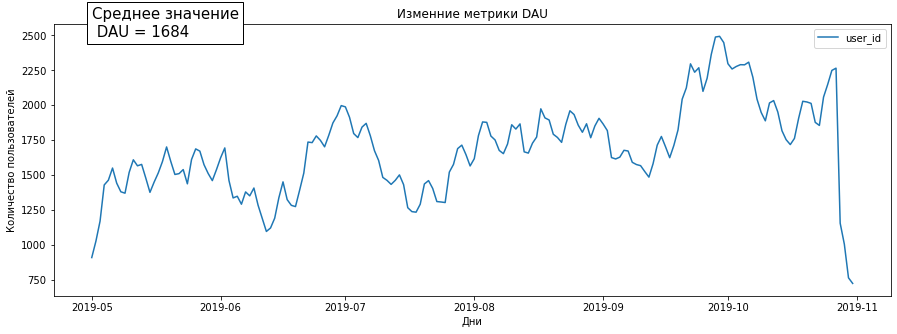

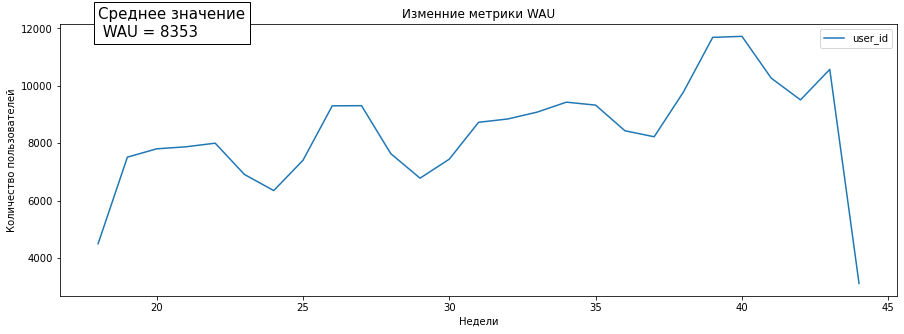

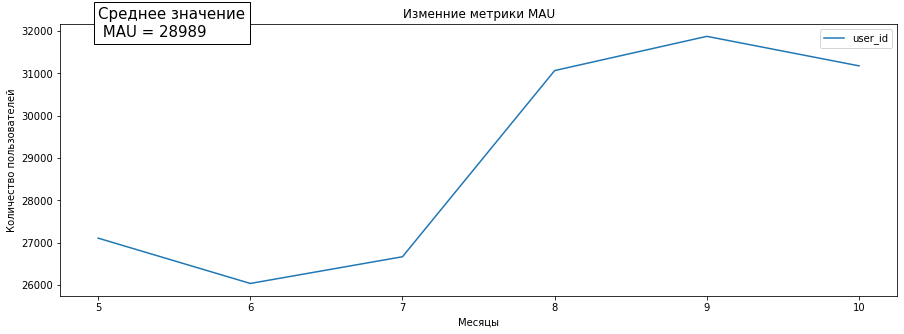

In [21]:
# В цикле построим сразу 3 графика - для дней, недель и месяцов:
# применим zip() для формирования подписей графика
for i, j in zip(['date', 'week', 'month'], ['Дни','Недели','Месяцы']):
    t = visits.groupby(i).agg({'user_id': 'nunique'})
    t.plot(figsize=(15,5))
    # добавим значение среднего сразу на график в виде текста в рамке:
    plt.text(t.reset_index().iloc[0, 0], t.max(), 
         f'Среднее значение\n {i[0].upper()}AU = {int(t.mean())}', 
         size=15,
        bbox=dict(boxstyle="square", 
                   ec=(0., 0., 0.),
                   fc=(1., 1., 1.),
                   )
        )
    plt.title(f'Изменние метрики {i[0].upper()}AU')
    plt.xlabel(j)
    plt.ylabel('Количество пользователей')
    
    plt.show()
    

<a id='activity'></a>
Судя по всему пользователи привлекаются хорошо, прирост новых посещений заметно вырос с июля.

Изучим число пользовательских сессий, построив гистограмму, отражающую распределение общего числа сессий в день, и выведелим среднее количество сессий в день.

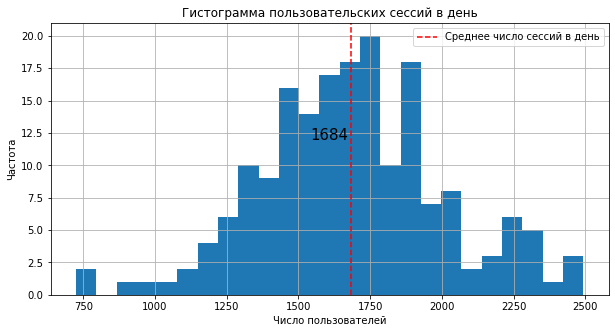

In [22]:
# Агрегируем данные по дням и считаем всех пользователей (не уникальных):
session_avg_day = visits.groupby('date').agg({'user_id': 'count'})

# Строим гистрограмму:
session_avg_day.hist(figsize=(10,5), bins=25)
plt.title('Гистограмма пользовательских сессий в день')
plt.xlabel('Число пользователей')
plt.ylabel('Частота')

# Отрисуем вертикальной линией значение среднего:
plt.axvline(x=session_avg_day['user_id'].mean(),
           color='r', linestyle='--', label='Среднее число сессий в день')

# И подпишем, чему конкретно равно это среднее:
plt.text(session_avg_day['user_id'].mean() - 10,
        12, f'{int(session_avg_day.mean())}',
        size=15, ha='right')

plt.legend()
plt.show()

Так как в данных таблицы все юзеры уникальны, без повторений, и каждый, получается заходил один раз, то среднее число пользовательских сессий соответствует DAU. Мы видим более или менее нормальное распределение с некоторыми выбросами.

Узнайте, сколько длится одна сессия. Постройте гистограмму, отражающую распределение длительности сессий. Применяя метод describe(), постройте таблицу с параметрами распределения. Изучать изменение этой метрики во времени необязательно.

Вычислим длительность каждой сессии:

In [23]:
# Создаем колонку со значением длительности:

visits['session_duration'] = (visits['session_end'] - visits['session_start']).dt.seconds
visits.head()

,user_id,region,device,channel,session_start,session_end,date,week,month,session_duration
0,981449118918,United States,iPhone,organic,2019-05-01 02:36:01,2019-05-01 02:45:01,2019-05-01,18,5,540
1,278965908054,United States,iPhone,organic,2019-05-01 04:46:31,2019-05-01 04:47:35,2019-05-01,18,5,64
2,590706206550,United States,Mac,organic,2019-05-01 14:09:25,2019-05-01 15:32:08,2019-05-01,18,5,4963
3,326433527971,United States,Android,TipTop,2019-05-01 00:29:59,2019-05-01 00:54:25,2019-05-01,18,5,1466
4,349773784594,United States,Mac,organic,2019-05-01 03:33:35,2019-05-01 03:57:40,2019-05-01,18,5,1445


Построим гистограмму длительности сессий

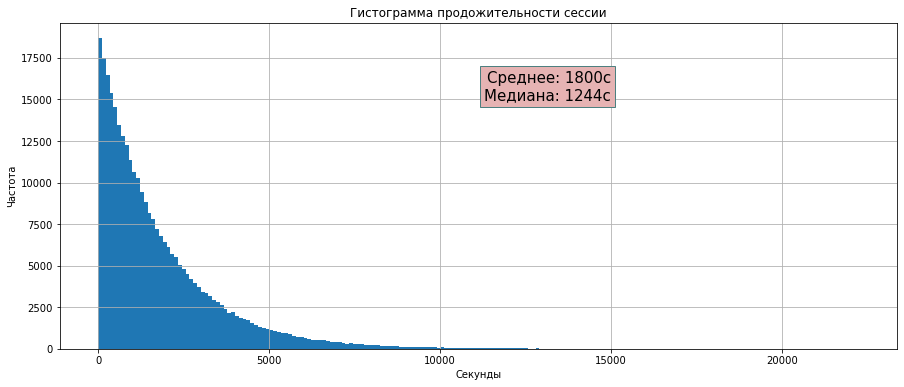

,user_id,week,month,session_duration
count,3.099010e+05,309901.000000,309901.000000,309901.000000
mean,4.997664e+11,31.714780,7.677171,1800.090868
std,2.887899e+11,7.508545,1.702601,1803.063525
min,5.993260e+05,18.000000,5.000000,0.000000
25%,2.493691e+11,25.000000,6.000000,517.000000
50%,4.989906e+11,32.000000,8.000000,1244.000000
75%,7.495211e+11,39.000000,9.000000,2497.000000
max,9.999996e+11,44.000000,10.000000,22257.000000


In [24]:
# строим сразу по колонке:
visits['session_duration'].hist(bins=200, figsize=(15, 6))

# Выводим в рамочке значения средней и медианной длительности сессии:
plt.text(15000, 15000, 
         f'Среднее: {int(visits.session_duration.mean())}с\nМедиана: {int(visits.session_duration.median())}с',
        size=15, ha='right', bbox=dict(boxstyle="square", 
                   ec=(0.3, 0.5, 0.5),
                   fc=(0.9, 0.7, 0.7),
                   ))
plt.title('Гистограмма продожительности сессии')
plt.xlabel('Секунды')
plt.ylabel('Частота')
plt.show()

# В подтверждение, что данные на графике верны выведем статистическую информацию о таблице:
visits.describe()

Описательная таблица:

In [25]:
visits['session_duration_min'] = (visits['session_end'] - visits['session_start']).dt.seconds/60
visits[['session_duration_min']].describe()

,session_duration_min
count,309901.000000
mean,30.001514
std,30.051059
min,0.000000
25%,8.616667
50%,20.733333
75%,41.616667
max,370.950000


<a id='timing'></a>
Распределение для длительности вполне нормальное. Пользователи проводят в приложении в среднем 30 мин, медианное среднее около 20 мин. Разница между медианой и средним 10 минут, наверное, не такая и большая. Судить о том, достаточное это время или нет без уточнения нельзя. Но, попрокрастинировать 20-30 мин бывает вполне достаточно. То есть приложение способно занять человека на какое-то время перерыва. А у кого-то перерыв длится 6 часов :)

### Исследование продаж <a id='research_sellout'></a>

Исследуем, сколько времени в среднем проходит с момента первого посещения до покупки. 

В этом месте проекта я крайне сомневаюсь в своем подходе. Наверное, немного запуталась.
Я создам новый датафрейм, где по сути присоединю данные из профилей пользователей к таблице заказов:

In [26]:
# соединяем таблички правым мерджем:
profile_d = profiles.merge(orders, on='user_id', how='right')

# Группирем по пользователям и оставляем тольо первые визиты и первые заказы:
# и смотрим, что получилось:
df_describer(
    profile_d.groupby('user_id')
    .agg({'first_ts': 'first', 'event_dt': 'first'}) # берем first(), так как важна 1-ая покупка после 1-ого визита
    .assign(delta = lambda x: x['event_dt'] - x['first_ts'])
)

Общая информация о таблице: 
<class 'pandas.core.frame.DataFrame'>
Int64Index: 8881 entries, 599326 to 999895427370
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype          
---  ------    --------------  -----          
 0   first_ts  8881 non-null   datetime64[ns] 
 1   event_dt  8881 non-null   datetime64[ns] 
 2   delta     8881 non-null   timedelta64[ns]
dtypes: datetime64[ns](2), timedelta64[ns](1)
memory usage: 277.5 KB
None
Пропуски в данных: 


,Nan,"Nan, %"
first_ts,0.000000,0.0%
event_dt,0.000000,0.0%
delta,0.000000,0.0%


Количество дублей: 
0
Описание данных


,first_ts,event_dt,delta
count,8881,8881,8881
unique,8877,8876,NaN
top,2019-08-03 08:55:43,2019-10-25 16:24:24,NaN
freq,2,2,NaN
first,2019-05-01 00:27:57,2019-05-01 00:28:11,NaN
last,2019-10-27 23:29:52,2019-10-31 22:46:19,NaN
mean,NaN,NaN,1 days 21:11:20.986488008
std,NaN,NaN,6 days 00:52:20.045661202
min,NaN,NaN,0 days 00:00:00
25%,NaN,NaN,0 days 00:00:10


1) зададим правильное имя: df_describer не отражает сути, рискну предложить first_order 2) сгруппируем таблицу, как ты это делаешь, сделаем аггрегацию по event_dt 3) затем примерджим profiles[['user_id', 'first_ts']] по user_id 4) затем найдем дельту первой покупки и переведем значения в минуты

In [27]:
first_order = (
    orders.groupby('user_id')
    .agg({'event_dt': 'first'}).reset_index()
    .merge(profiles[['user_id', 'first_ts']], on='user_id')
    .assign(delta = lambda x: x['event_dt'] - x['first_ts'])
)

first_order.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8881 entries, 0 to 8880
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype          
---  ------    --------------  -----          
 0   user_id   8881 non-null   int64          
 1   event_dt  8881 non-null   datetime64[ns] 
 2   first_ts  8881 non-null   datetime64[ns] 
 3   delta     8881 non-null   timedelta64[ns]
dtypes: datetime64[ns](2), int64(1), timedelta64[ns](1)
memory usage: 346.9 KB


In [28]:
first_order['delta'] = first_order['delta'].apply(lambda x: x.total_seconds() / 60)
first_order[['delta']].describe()

,delta
count,8881.000000
mean,2711.349775
std,8692.334094
min,0.000000
25%,0.166667
50%,0.550000
75%,2128.016667
max,190314.550000


<a id='decision'></a>
Медианное время принятия решения о покупке приложения составляет полминуты, между тем среднее почти 2 дня. Такая разница возникла из-за того, что есть пользователи, которые купили приложение лишь через 132 дня. В целом принятие решения покупки приложения довольно быстрое, почти молниеностное. Это не всегда хорошо - дешевый продукт легко купить и забыть о нем.

Рассчитаем среднее число покупок на одного покупателя за день, неделю и месяц. Постройте графики изменения этих метрик во времени.

In [29]:
# создадим колонки с днями/неделями/месяцами продаж:

profile_d['event_day'] = profile_d['event_dt'].dt.date
profile_d['event_week'] = profile_d['event_dt'].dt.week
profile_d['event_month'] = profile_d['event_dt'].dt.month

Я тут не знала, какую визуализацию предложить... Сделала точечную в итоге - хоть видно, как распределось число покупок. А потом и гистограмму все-таки дорисовала - ибо надо бооольше визуализации) Но почему-то в окружении Яндекс.Практикума у меня код выдал ошибку. Наверное, пандас старый, которому нужны для точечных диаграмм только численные данные.

In [30]:
# Зададим счетчик для расстановки графиков по полям:
#n=0
#fig = plt.subplots(figsize=(20, 20))
#
## В цикле отрисовываем 6 графиков: 3 точечных диаграммы и 3 гистограммы, все со своими координатами:
#for i, j in zip(['event_day', 'event_week', 'event_month'], ['Дни','Недели','Месяцы']):
#    # Агрегационная функция count(), так как раз посчитаем все заказы на 
#    t = profile_d.groupby([i, 'user_id']).agg({'revenue': 'count'}).reset_index()
#    n=n+1
#    t.plot(kind='scatter', ax=plt.subplot(3, 2, n), x = i, y = 'revenue', 
#           alpha=0.25, ylabel = j, xlabel = 'Количество заказов на человека', 
#           title='Точечная диаграмма', s=(20 * np.random.rand(len(t.revenue)))**2)
#    n=n+1
#    t.plot(kind='hist', ax=plt.subplot(3, 2, n), y = 'revenue', x = i, bins=25,
#          ylabel = 'Частота', xlabel = 'Количество заказов на человека', 
#           title=f'Гистограмма, среднее в \n{j} = {round(t.revenue.mean(), 2)} заказа/ов на человека')
#    
#    
#plt.show()

В итоге быстро накидала гистограммы:

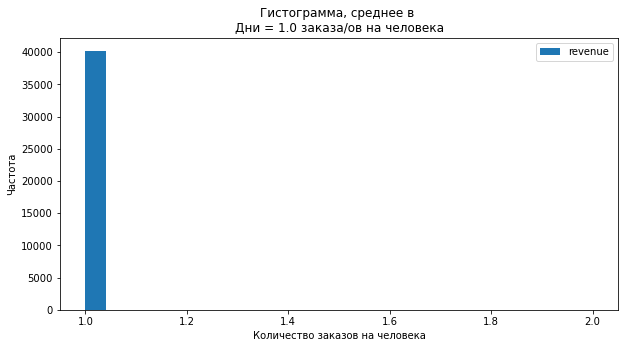

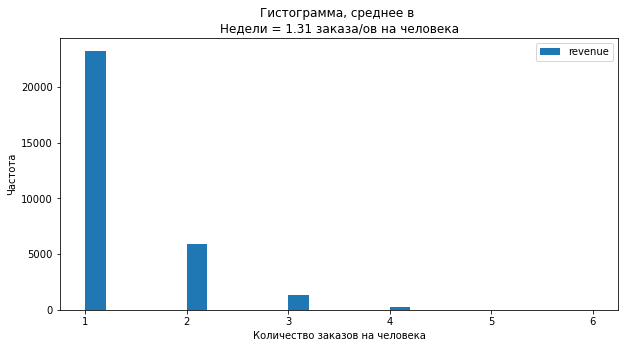

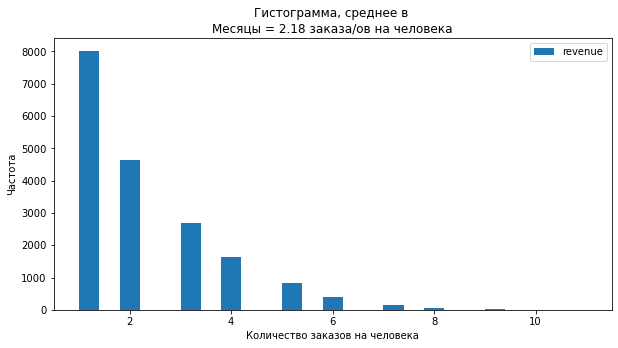

In [31]:
for i, j in zip(['event_day', 'event_week', 'event_month'], ['Дни','Недели','Месяцы']):
    # Агрегационная функция count(), так как раз посчитаем все заказы на 
    t = profile_d.groupby([i, 'user_id']).agg({'revenue': 'count'}).reset_index()
    
    t.plot(kind='hist', y = 'revenue', x = i, bins=25, figsize=(10,5))
    plt.ylabel('Частота')
    plt.xlabel('Количество заказов на человека')
    plt.title(f'Гистограмма, среднее в \n{j} = {round(t.revenue.mean(), 2)} заказа/ов на человека')
    plt.show()

<a id='avh_sell_count'></a>
Вот тут я очень сомневаюсь, на меня внезапно нашел тупняк. И с визуализацией и с самой задачей... Я пробовала применить сглаживание при обычном линейном графике, но ничего не сработало: график получился непонятным, слишком маленький набор значений получается.


В общем, в среднем и день и в неделю один пользователь совершает одну покупку. В день редко кто совершает больше одной покупки вообще. В месяц набирается в среднем на 2 покупки. Максимум покупок одним пользователем в месяц - 11. Можно сказать, что здесь стабильно, без роста.

Рассчитаем средний чек за день, неделю и месяц. Для построения графиков изменения этих метрик во времени введем функцию сглаживания:

И другой тип визуализации:

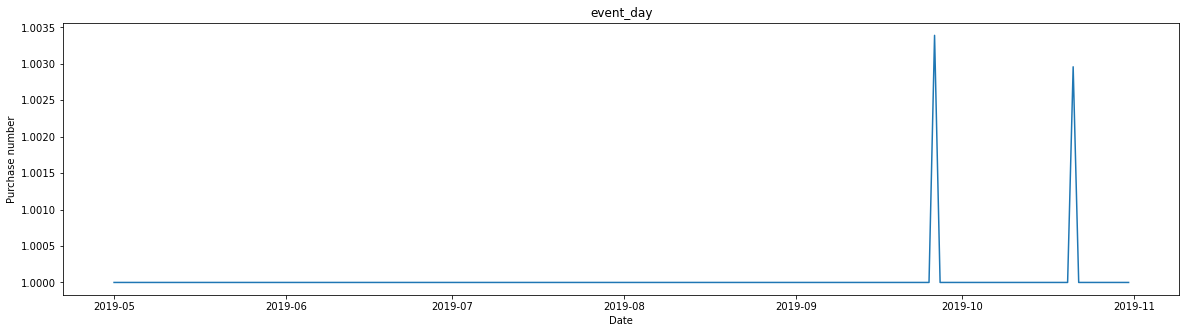

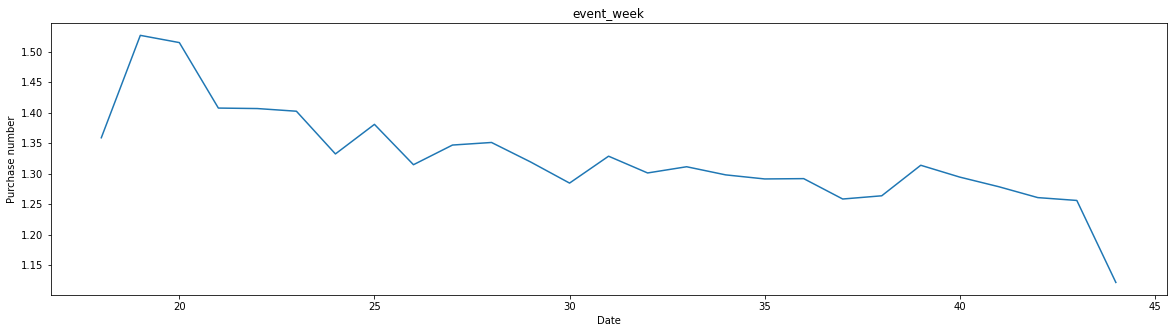

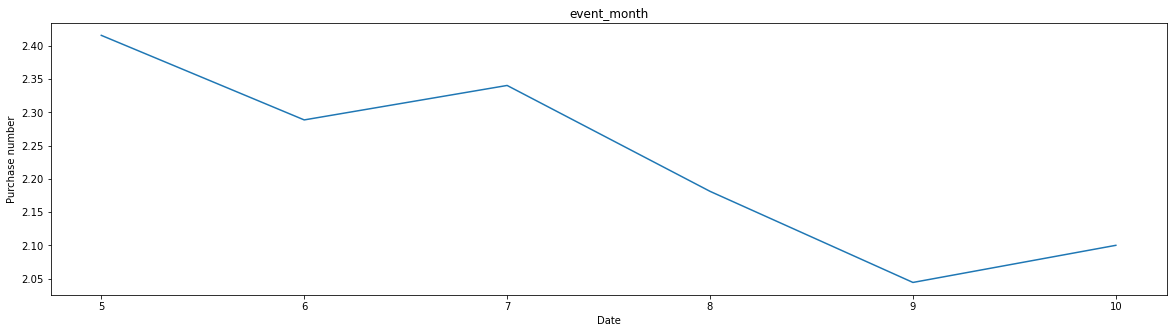

In [32]:
for i in list(['event_day', 'event_week', 'event_month']):
    plt.figure(figsize = (20, 5))
    plt.title(i)
    plt.xlabel('Date')
    plt.ylabel('Purchase number')
    plt.plot(
                profile_d
                .groupby(['user_id', i])
                ['event_dt'].count()
                .reset_index()
                .groupby(i)
                .agg({'event_dt': 'mean'})
            )

    plt.show()

In [33]:
def filter_data(df, window):
    '''
    Принимает таблицу и ширину окна сглаживания.
    Вернет таблицу со значениями в колонках, пропущенных через rolling()
    '''
    # для каждого столбца применяем скользящее среднее
    for column in df.columns.values:
        df[column] = df[column].rolling(window).mean() 
    return df

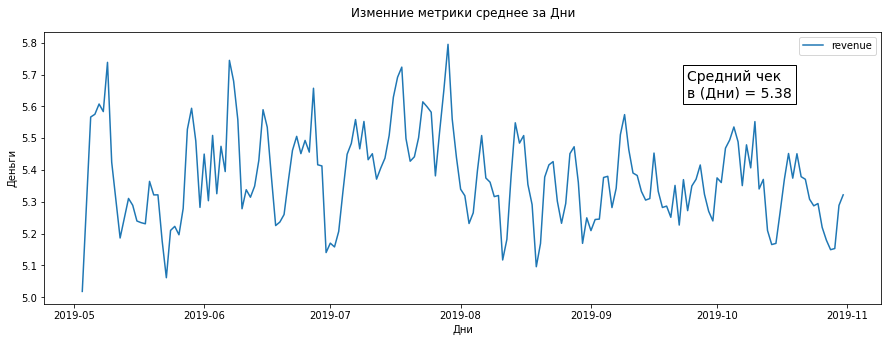

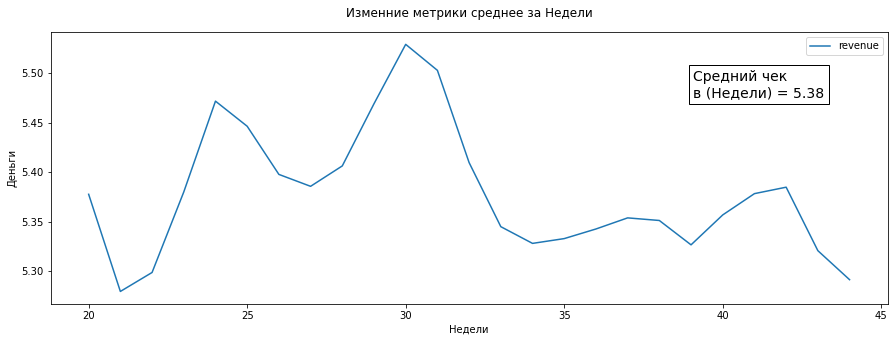

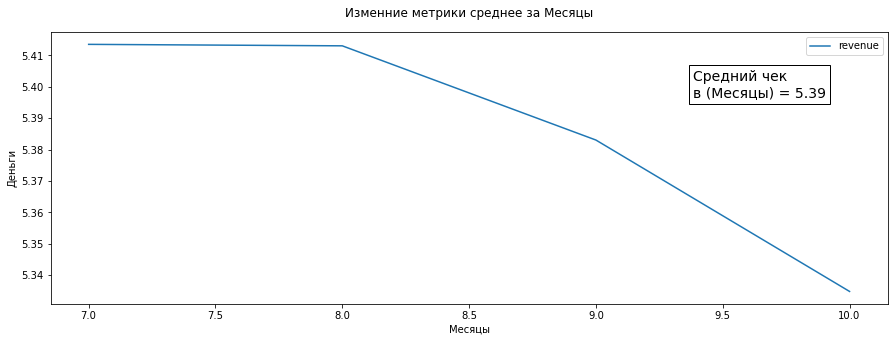

In [34]:
# Циклом, похожим на предыдущий, отрисовываем графики друг под другом:
for i, j in zip(['event_day', 'event_week', 'event_month'], ['Дни','Недели','Месяцы']):
    t = profile_d.groupby([i]).agg({'revenue': 'mean'})
    filter_data(t, 3).plot(figsize=(15,5))
    
    # Выводим значение срезнего чека на поле графика в рамке:
    plt.figtext(0.72, 0.7,  
         f'Средний чек \nв ({j}) = {round(t.revenue.mean(), 2)}', 
         size=14, va='baseline', 
        bbox=dict(boxstyle="square", 
                   ec=(0., 0., 0.),
                   fc=(1., 1., 1.),
                   )
        )
    plt.title(f'Изменние метрики среднее за {j}', pad = 15)
    plt.xlabel(j)
    plt.ylabel('Деньги')
    plt.show()

<a id='avh_cheque'></a>
Казалось бы такие пики, такие и взлеты и падения... Но все это в очень-очень большом приближении, под микроскопом.
По сути, время идет и ничего не меняется. Кто-то говорит стабильность, а кто-то - стагнация.

**В итоге** мы имеем картину застоя по всем фронтам: 
- средний чек не растет, 
- количество покупок не увеличивается. 

Вместе с тем, пользователи совсем не против посидеть в нашем приложении (медианной время ок 20мин) и вполне активно привлекаются - идет большой прирост новых юзеров, которые быстро принимают решение о покупке (если заинтересовываются, быстро покупают не думая ни минуты, ну 2 минуты). 

<a id='research_marketing'></a>
### Маркетинговые исследования

Посчитаем общую сумму расходов на маркетинг. Выясним, как траты распределены по источникам и визуализируем изменения метрик во времени.

Для этого обратимся к табличке со стоимостью рекламы: <a id='adv_cost'></a>

Text(0, 0.5, 'Расходы')

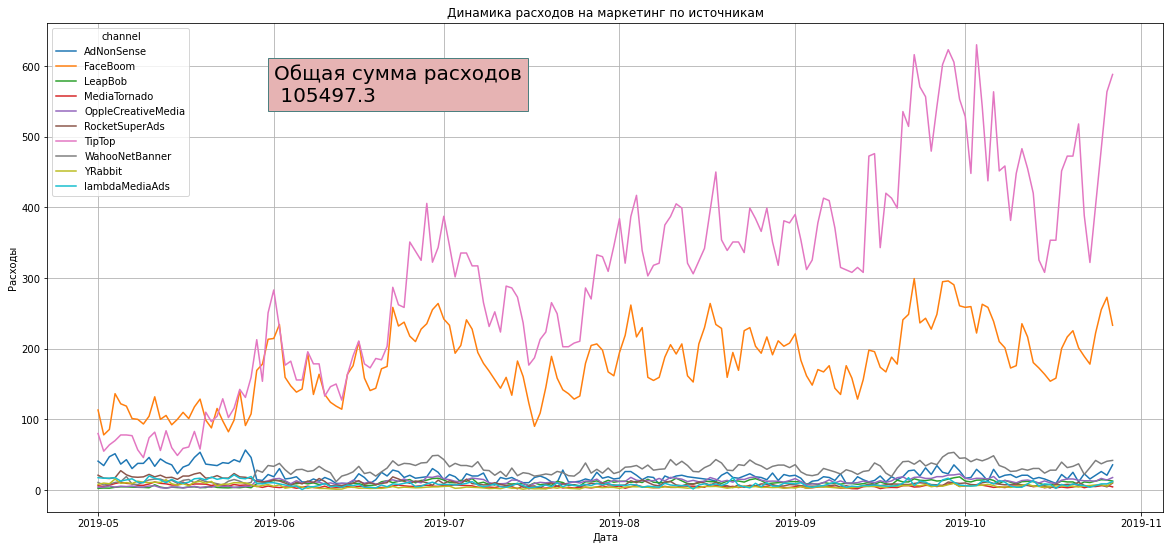

In [35]:
# создаем сводную и от нее сразу строим график:
(costs
 .pivot_table(index='dt', columns='channel', values='costs', aggfunc='sum')
 .plot(grid=True, figsize=(20,9))
)
# добавляем красивый текст в рамочке. Ну типа красивый...
plt.text('2019-06', 550, 
         f'Общая сумма расходов\n {round(costs.costs.sum(), 2)}', 
         size=20,
        bbox=dict(boxstyle="square", 
                   ec=(0.3, 0.5, 0.5),
                   fc=(0.9, 0.7, 0.7),
                   )
        )
plt.title('Динамика расходов на маркетинг по источникам')
plt.xlabel('Дата')
plt.ylabel('Расходы')


Из графика видно, что самыми дорогостоящими источниками являются TipTop и FaceBoom, расходы на остальные рекламные источники меркнут в сравнении с ними. Общая сумма расходов на каналы составила 105 497.3 каких-то денег.

Узнаем, сколько в среднем стоило привлечение одного пользователя из каждого источника. Рассчитаем средний CAC на одного пользователя для всего проекта и для каждого источника трафика, используя профили пользователей. <a id='avh_adv_cost'></a>

Text(0, 0.5, 'Каналы привлечения')

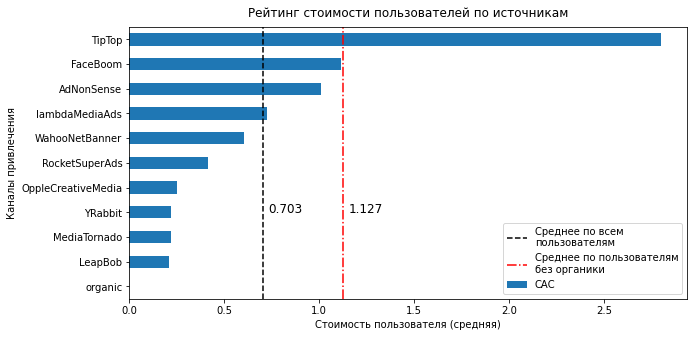

In [36]:
# Рисуем график, агрегируя средний САС по каналам:
(
    profiles.groupby('channel')
    .agg({'acquisition_cost':'mean'})
    .sort_values(by='acquisition_cost')
).plot.barh(figsize=(10, 5))

# Отрисуем линию, отмечающую общее среднее САС
plt.axvline(profiles['acquisition_cost'].mean(), color='black', 
            linestyle='--')

plt.axvline(profiles[profiles['channel'] != 'organic']['acquisition_cost'].mean(), color='red', 
            linestyle='-.')
# отметим числовое значение среднего САС по всем пользователям
plt.text(profiles['acquisition_cost'].mean() + 0.03,
        3, f'{round(profiles.acquisition_cost.mean(), 3)}',
        size=12, ha='left')
# и без учета пришедших органическим путем
avg_w_organic = profiles[profiles['channel'] != 'organic']['acquisition_cost'].mean()
plt.text(avg_w_organic + 0.03,
        3, f'{round(avg_w_organic, 3)}',
        size=12, ha='left')

plt.legend(['Среднее по всем \nпользователям', 'Среднее по пользователям\nбез органики', 'САС'])
plt.title('Рейтинг стоимости пользователей по источникам', pad = 10)
plt.xlabel('Стоимость пользователя (средняя)')
plt.ylabel('Каналы привлечения')


В среднем по всем пользователям средний САС получился 0.7, если же смотреть по каналам, то самые дорогие пользватели из TipTop'а.
Пока не очень понятно, стоят ли они затраченных на них средств.





In [37]:
profiles[profiles['channel'] != 'organic']['acquisition_cost'].mean()

1.127481323942928

Оценим окупаемость рекламы, используя графики LTV, ROI и CAC, и проанализируем окупаемость рекламы. Нам сказали считать, что на календаре 1 ноября 2019 года (момент анализа, значит), а в бизнес-плане заложено, что пользователи должны окупаться не позднее чем через две недели (горизон анализа) после привлечения. Необходимость включения в анализ органических пользователей определите самостоятельно.

Органических пользователей буду исключать, так как их много, они могут смазать картину.


Проанализируем общую окупаемость рекламы, построив графики LTV и ROI, а также графики динамики LTV, CAC и ROI.

In [38]:
# Задаем момент анализа
observation_date = datetime(2019, 11, 1).date()
# Задаем горизонт анализа
horizon_days = 14

# Используя функцию, определенную выше, зададим таблицы LTV и ROI
ltv_raw, ltv, ltv_history, roi, roi_history = get_ltv_roi(
                                                             profiles[profiles['channel'] != 'organic'],
                                                             orders,
                                                             observation_date,
                                                             horizon_days,
                                                             dimensions=[],
                                                             ignore_horizon=False,
                                                         )

In [39]:
# Зададим функцию по отрисовке графиков LTV и ROI
def plot_ltv_roi(ltv, ltv_history, roi, roi_history, horizon, window=7):
    '''
    Принимает:
    ltv
    ltv в динамике
    roi
    roi в динамике
    день жизненного цикла (лайфтайм) на который мы смотрим динамику
    окно сглаживания
    '''

    # задаём сетку отрисовки графиков
    plt.figure(figsize=(20, 10))

    # из таблицы ltv исключаем размеры когорт
    ltv = ltv.drop(columns=['cohort_size'])
    # в таблице динамики ltv оставляем только нужный лайфтайм
    ltv_history = ltv_history.drop(columns=['cohort_size'])[[horizon - 1]]

    # стоимость привлечения запишем в отдельный фрейм
    cac_history = roi_history[['cac']]

    # из таблицы roi исключаем размеры когорт и cac
    roi = roi.drop(columns=['cohort_size', 'cac'])
    # в таблице динамики roi оставляем только нужный лайфтайм
    roi_history = roi_history.drop(columns=['cohort_size', 'cac'])[
        [horizon - 1]
    ]

    # первый график — кривые ltv
    ax1 = plt.subplot(2, 3, 1)
    ltv.T.plot(grid=True, ax=ax1)
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('LTV')

    # второй график — динамика ltv
    ax2 = plt.subplot(2, 3, 2, sharey=ax1)
    # столбцами сводной таблицы станут все столбцы индекса, кроме даты
    columns = [name for name in ltv_history.index.names if name not in ['dt']]
    filtered_data = ltv_history.pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax2)
    plt.xlabel('Дата привлечения')
    plt.title('Динамика LTV пользователей на {}-й день'.format(horizon))

    # третий график — динамика cac
    ax3 = plt.subplot(2, 3, 3, sharey=ax1)
    # столбцами сводной таблицы станут все столбцы индекса, кроме даты
    columns = [name for name in cac_history.index.names if name not in ['dt']]
    filtered_data = cac_history.pivot_table(
        index='dt', columns=columns, values='cac', aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax3)
    plt.xlabel('Дата привлечения')
    plt.title('Динамика стоимости привлечения пользователей')

    # четвёртый график — кривые roi
    ax4 = plt.subplot(2, 3, 4)
    roi.T.plot(grid=True, ax=ax4)
    plt.axhline(y=1, color='red', linestyle='--', label='Уровень окупаемости')
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('ROI')

    # пятый график — динамика roi
    ax5 = plt.subplot(2, 3, 5, sharey=ax4)
    # столбцами сводной таблицы станут все столбцы индекса, кроме даты
    columns = [name for name in roi_history.index.names if name not in ['dt']]
    filtered_data = roi_history.pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax5)
    plt.axhline(y=1, color='red', linestyle='--', label='Уровень окупаемости')
    plt.xlabel('Дата привлечения')
    plt.title('Динамика ROI пользователей на {}-й день'.format(horizon))

    plt.tight_layout()
    plt.show()

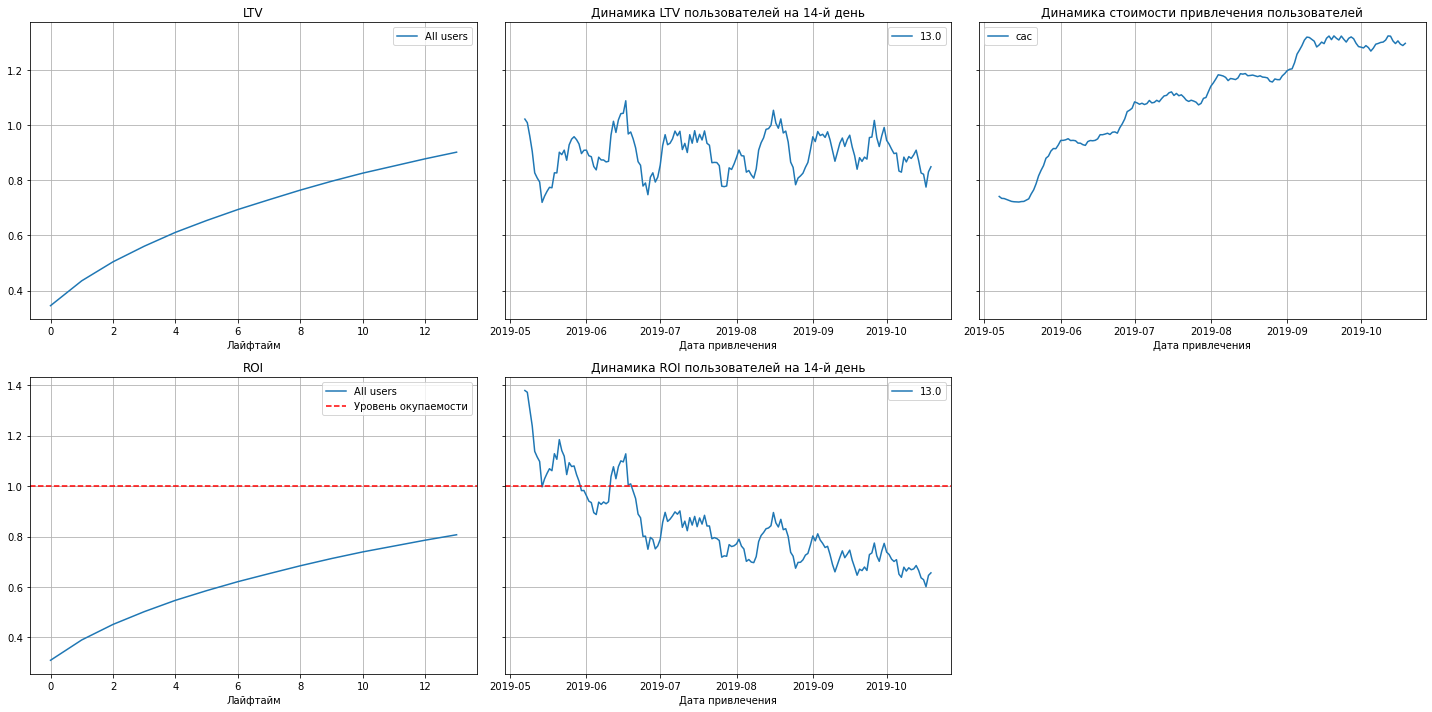

In [40]:
# рисуем красоту
plot_ltv_roi(ltv, ltv_history, roi, roi_history, 14)

<a id='cac_channel'></a>
Из графиков видно, что LTV имеет нормальный график - плавно растет к единице. 
Но вот со стоимостью привлечения все не так хорошо - мы видим стремительный рост динамики на протяжении всего периода, в то время как ROI еле-еле дотягивает до 0,8 к концу лайфтайма и на 14 день у нас пользователи не окупаются с середины июня.

Проанализируем окупаемость рекламы с разбивкой по рекламным каналам. 

In [41]:
# Строим  LTV/ROI по каналам
ltv_raw_ch, ltv_ch, ltv_history_ch, roi_ch, roi_history_ch = get_ltv_roi(
                                                             profiles[profiles['channel'] != 'organic'],
                                                             orders,
                                                             observation_date,
                                                             horizon_days,
                                                             dimensions=['channel'],
                                                             ignore_horizon=False,
                                                         )

Построим графики LTV и ROI, а также графики динамики LTV, CAC и ROI поканалам.

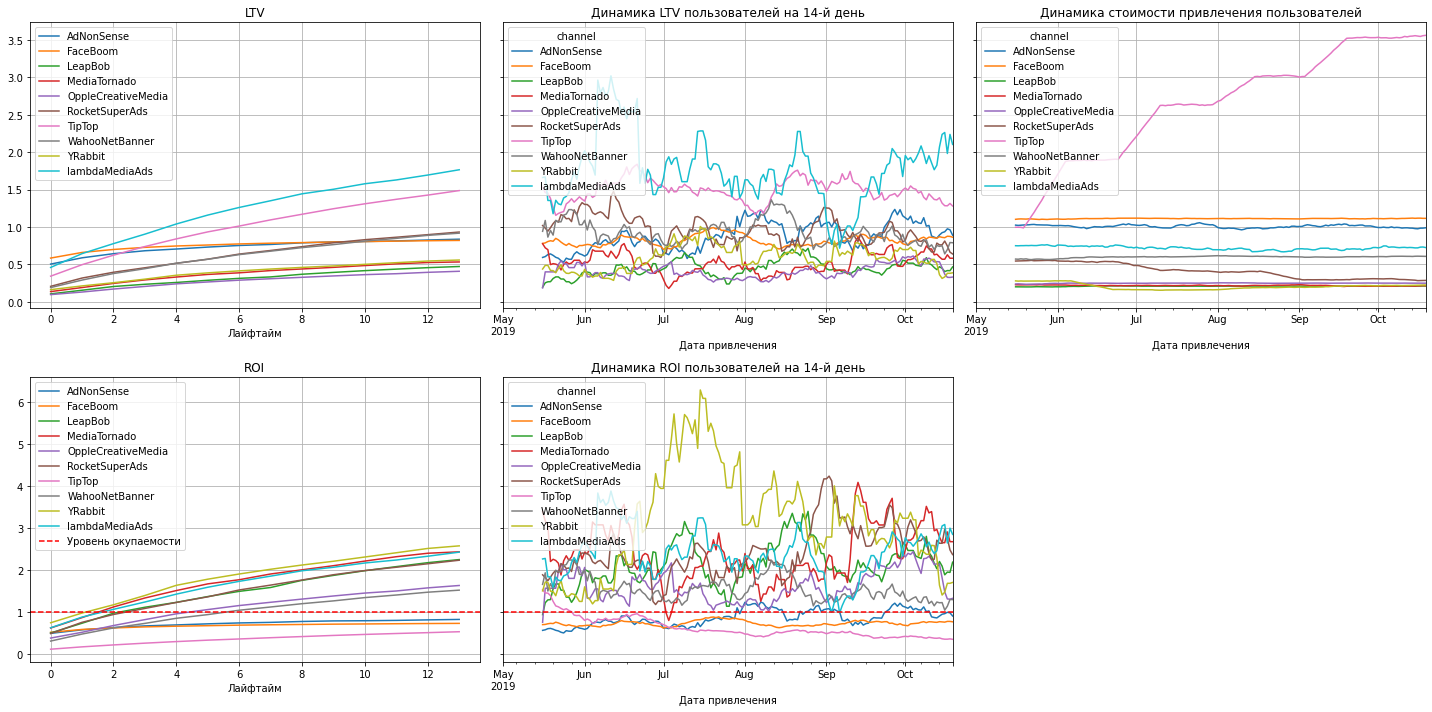

In [42]:
plot_ltv_roi(ltv_ch, ltv_history_ch, roi_ch, roi_history_ch, 14, window=16)

<a id='cac_channel'></a>
Ага! Видны первые причины проблем: 3 канала не окупаются, это TipTop, FaceBoom и AdNonSence. При этом помним, что TipTop и FaceBoom лидеры по числу привлеченных пользователей - их много и они дорогие.

Также стоит отметить, что TipTop (ввиду своей нарастающей популярности? :) ) примерно раз в полмесяца увеличивает стоимость рекламы - на графике динамики стоимости привлечения пользователей его линия ступенчато растет вверх.


Проанализируем окупаемость рекламы с разбивкой по странам. Постройте графики LTV и ROI, а также графики динамики LTV, CAC и ROI.

Посмотрим на распределение рекламных каналов по странам - какие и где есть:

Text(0, 0.5, 'Страны')

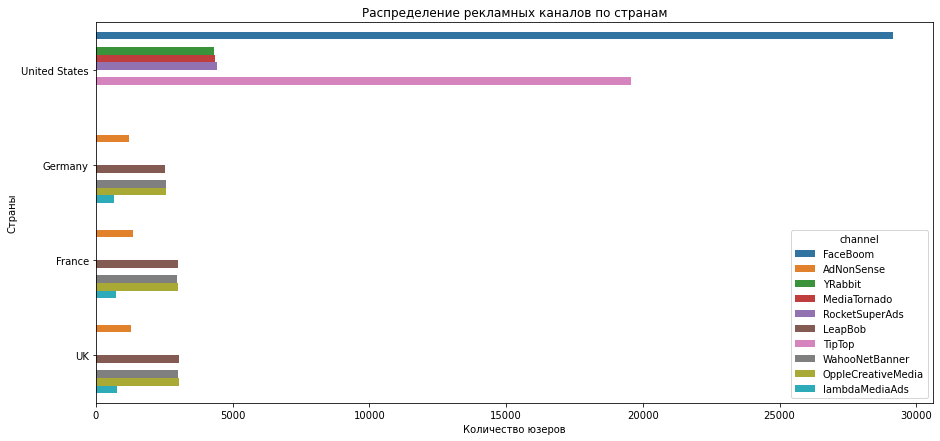

In [43]:
#profiles[profiles['channel'] != 'organic'].groupby(['region', 'channel'])['user_id'].count().plot(kind='barh')
plt.figure(figsize=(15, 7))
sns.countplot(y='region', hue='channel', data=profiles[profiles['channel'] != 'organic'], orient='h')
plt.title('Распределение рекламных каналов по странам')
plt.xlabel('Количество юзеров')
plt.ylabel('Страны')

In [44]:
ltv_raw_ct, ltv_ct, ltv_history_ct, roi_ct, roi_history_ct = get_ltv_roi(
                                                             profiles[profiles['channel'] != 'organic'],
                                                             orders,
                                                             observation_date,
                                                             horizon_days,
                                                             dimensions=['region'],
                                                             ignore_horizon=False,
                                                         )


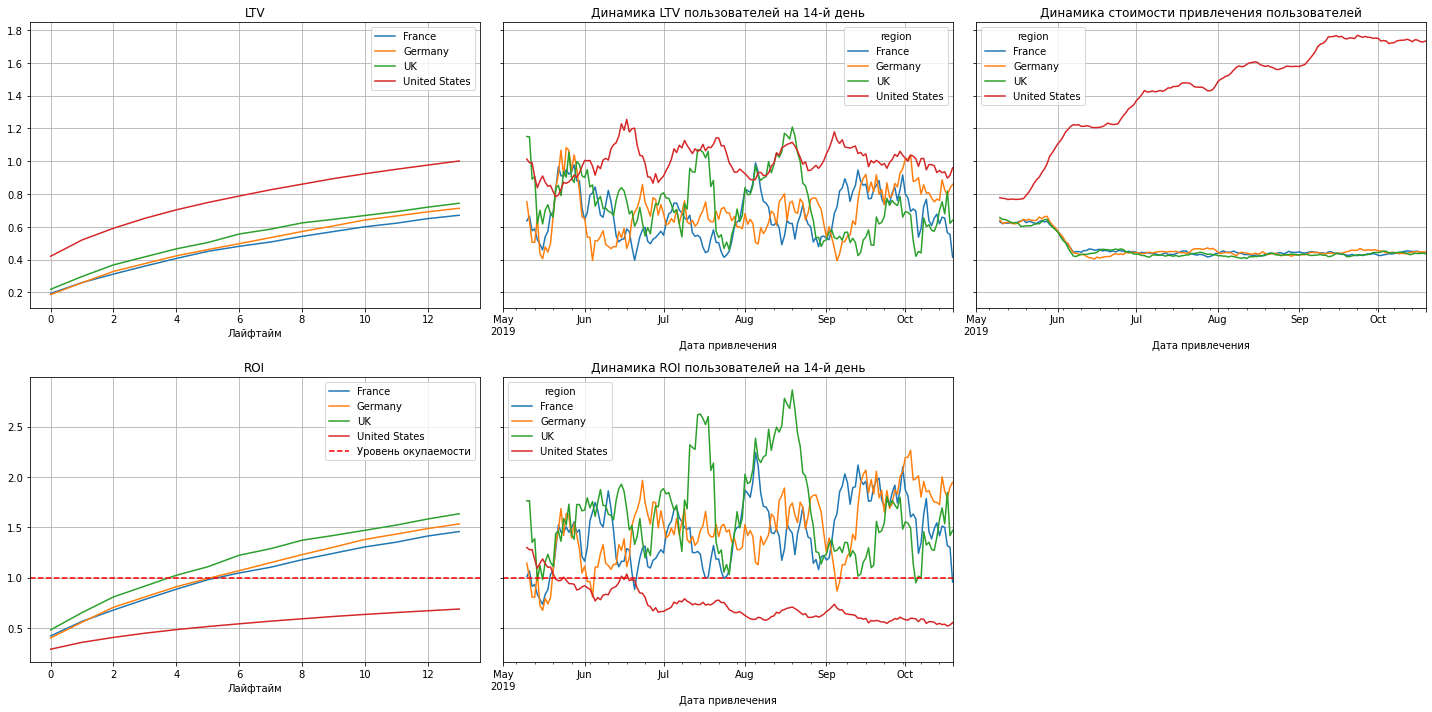

In [45]:
plot_ltv_roi(ltv_ct, ltv_history_ct, roi_ct, roi_history_ct, 14, window=10)

<a id='usa_cac'></a>
Мы видим, что поведение графика для США очень похоже на канал TipTop, вероятно, они и являются основными пользователями, привлекаемыми им - отсюда и низкий ROI для США. Остальные страны ведут себя очень схожим образом.

Проверим, какой канал привлечения основной для Америки:

In [46]:
(
    profiles[profiles['region'] == 'United States']
    .groupby('channel')
    .agg({'user_id': 'nunique', 'payer': 'sum'})
    .assign(rate = lambda x: x['payer'] / x['user_id'] * 100)
    .sort_values(by='user_id', ascending=False)
)

,user_id,payer,rate
channel,,,
organic,38173,794,2.080004
FaceBoom,29144,3557,12.204914
TipTop,19561,1878,9.600736
RocketSuperAds,4448,352,7.913669
MediaTornado,4364,156,3.574702
YRabbit,4312,165,3.826531


TipTop в США получается не основной, но второй по популярности, если не считать органику. Да и вообще, получается, что в США больше 2/3 платной аудитории приходят через очень дорогие источники, которые себя не окупают. А мы помним, что в основном наши пользователи из США.

Построим и изучим графики конверсии и удержания с разбивкой по устройствам, странам, рекламным каналам.
Ответим на такие вопросы:
- Окупается ли реклама в целом?
- Какие устройства, страны и каналы могут снижать окупаемость рекламы?
- Чем могут быть вызваны проблемы окупаемости?

In [47]:
# Начнем с удержания без доп.параметров, зададим таблицы с помощью функции, объявленной в начале тетради:
retention_raw, retention, retention_history = get_retention(
                                                        profiles[profiles['channel'] != 'organic'],
                                                        visits,
                                                        observation_date,
                                                        horizon_days,
                                                        dimensions=[],
                                                        ignore_horizon=False,
                                                    )

Зададим функцию визуализации удержания:

In [48]:
def plot_retention(retention, retention_history, horizon, window=7):
    '''
    Принимает таблицы удержания и динамики удержания;
    горизонт событий,
    окно сглаживания (по умолчанию 7)
    Вернет графики удержания и динамики удержания
    '''

    # задаём размер сетки для графиков
    plt.figure(figsize=(15, 10))

    # исключаем размеры когорт и удержание первого дня
    retention = retention.drop(columns=['cohort_size', 0])
    # в таблице динамики оставляем только нужный лайфтайм
    retention_history = retention_history.drop(columns=['cohort_size'])[
        [horizon - 1]
    ]

    # если в индексах таблицы удержания только payer,
    # добавляем второй признак — cohort
    if retention.index.nlevels == 1:
        retention['cohort'] = 'All users'
        retention = retention.reset_index().set_index(['cohort', 'payer'])

    # в таблице графиков — два столбца и две строки, четыре ячейки
    # в первой строим кривые удержания платящих пользователей
    ax1 = plt.subplot(2, 2, 1)
    retention.query('payer == True').droplevel('payer').T.plot(
        grid=True, ax=ax1
    )
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('Удержание платящих пользователей')

    # во второй ячейке строим кривые удержания неплатящих
    # вертикальная ось — от графика из первой ячейки
    ax2 = plt.subplot(2, 2, 2, sharey=ax1)
    retention.query('payer == False').droplevel('payer').T.plot(
        grid=True, ax=ax2
    )
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('Удержание неплатящих пользователей')

    # в третьей ячейке — динамика удержания платящих
    ax3 = plt.subplot(2, 2, 3)
    # получаем названия столбцов для сводной таблицы
    columns = [
        name
        for name in retention_history.index.names
        if name not in ['dt', 'payer']
    ]
    # фильтруем данные и строим график
    filtered_data = retention_history.query('payer == True').pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax3)
    plt.xlabel('Дата привлечения')
    plt.title(
        'Динамика удержания платящих пользователей на {}-й день'.format(
            horizon
        )
    )

    # в четвёртой ячейке — динамика удержания неплатящих
    ax4 = plt.subplot(2, 2, 4, sharey=ax3)
    # фильтруем данные и строим график
    filtered_data = retention_history.query('payer == False').pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax4)
    plt.xlabel('Дата привлечения')
    plt.title(
        'Динамика удержания неплатящих пользователей на {}-й день'.format(
            horizon
        )
    )
    
    plt.tight_layout()
    plt.show()


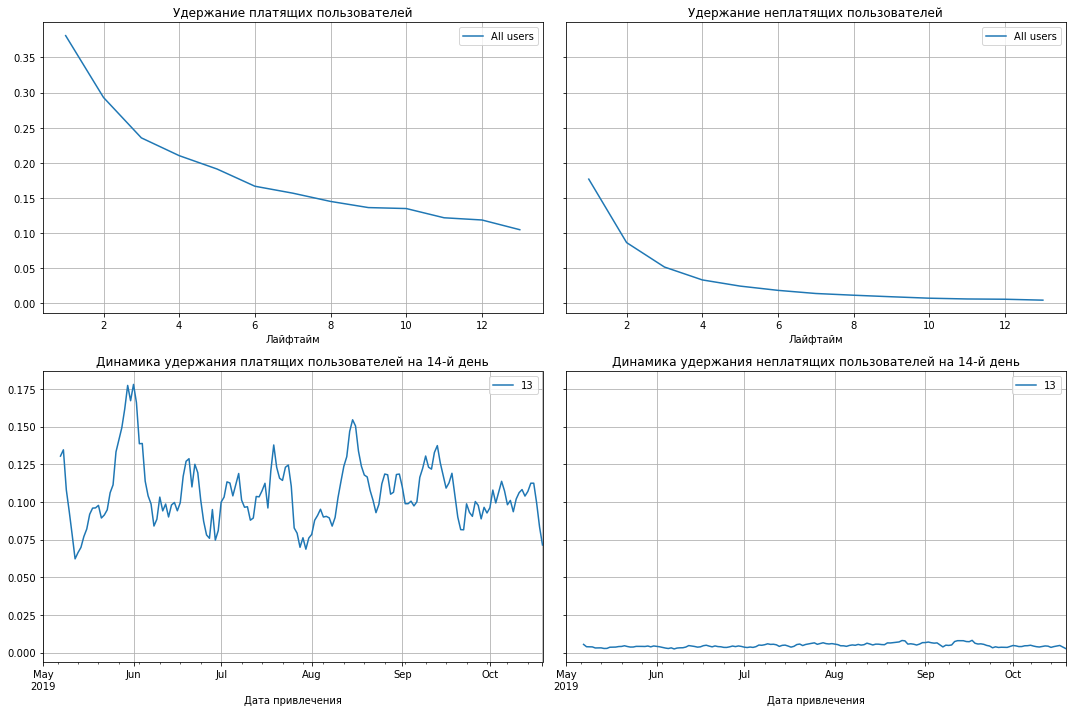

In [49]:
# строим графики
plot_retention(retention, retention_history, 14)

Графики не вызывают особых инсайтов - все штатно. Удержание на 14 день платящих примерно 10%, кривые постепенно падают - нормальная ситуация. Рассмотрим для устройтсв:

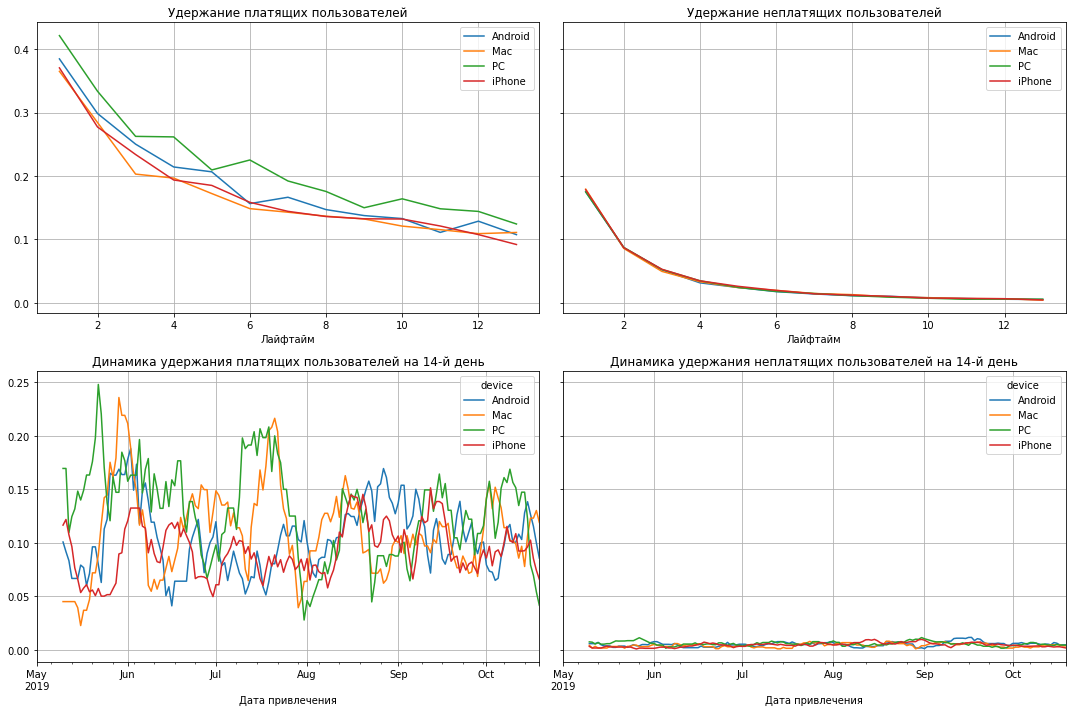

In [50]:
# Задаем доп.параметр divice в аргементе dimentions
retention_raw_dv, retention_dv, retention_history_dv = get_retention(
                                                        profiles[profiles['channel'] != 'organic'],
                                                        visits,
                                                        observation_date,
                                                        horizon_days,
                                                        dimensions=['device'],
                                                        ignore_horizon=False,
                                                    )
# И сразу визуализируем:
plot_retention(retention_dv, retention_history_dv, 14, window=10)

Ничего криминального не видно. Возможно, стоит заметить, что устройтсва на iOS несколько хуже удержаваются, но в данном случае это не повод для паники.
<a id='retantion_reg'></a>
Посмотрим на страны:

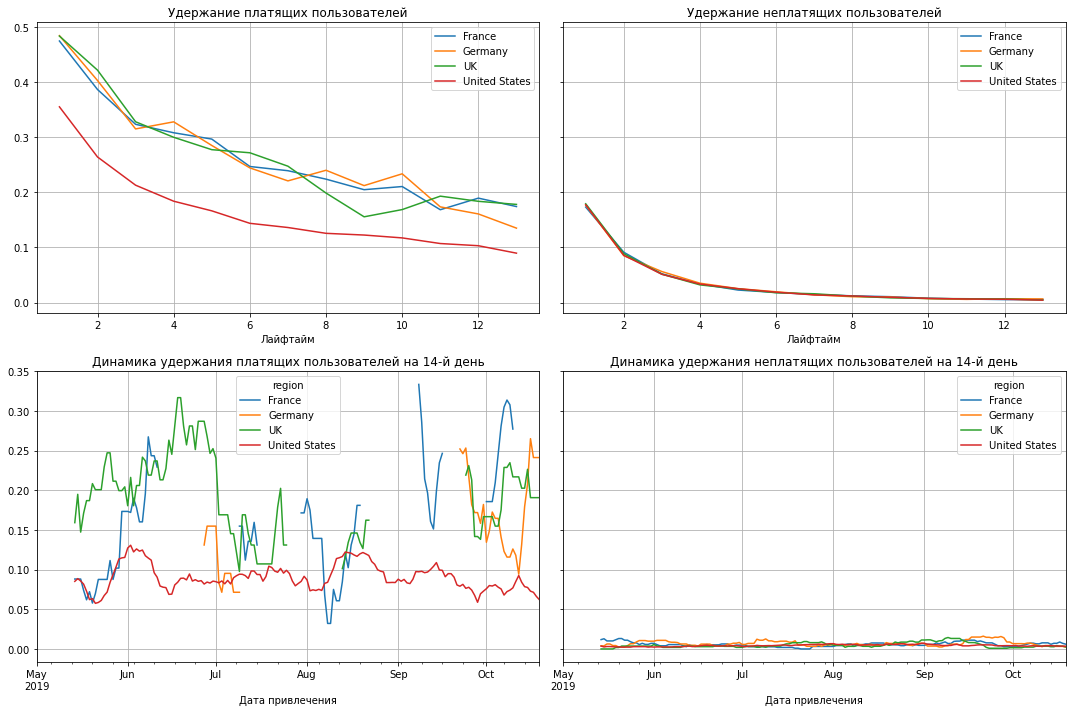

In [51]:
# Задаем доп.параметр region в аргементе dimentions
retention_raw_ct, retention_ct, retention_history_ct = get_retention(
                                                        profiles[profiles['channel'] != 'organic'],
                                                        visits,
                                                        observation_date,
                                                        horizon_days,
                                                        dimensions=['region'],
                                                        ignore_horizon=False,
                                                    )
# И сразу визуализируем:
plot_retention(retention_ct, retention_history_ct, 14, window=14)

Из графиков можно сделать вывод, что удержание у пользователей из США ниже, чем у остальных. То есть они и дорогие и не надежные.

И каналы:

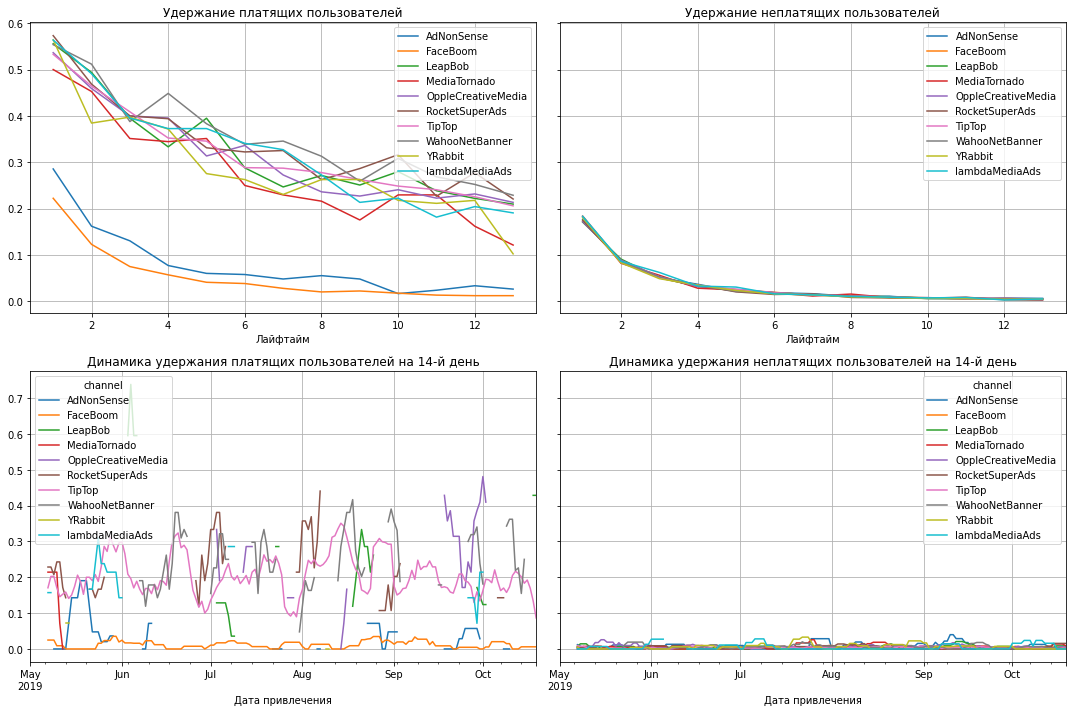

In [52]:
retention_raw_ch, retention_ch, retention_history_ch = get_retention(
                                                        profiles[profiles['channel'] != 'organic'],
                                                        visits,
                                                        observation_date,
                                                        horizon_days,
                                                        dimensions=['channel'],
                                                        ignore_horizon=False,
                                                    )
plot_retention(retention_ch, retention_history_ch, 14)

<a id='retantion_chan'></a>
Что ж, уже ожидаемая картина - удержание остает у FaceBoom и AdNonSence, а вот у TipTop - нормальное удержание.

Посмотрим, как обстоит дело с конверсией.
Запишем функцию для визуализации коверсии:

In [53]:
# зададим функцию для построения графиков конверсии:
def plot_conversion(conversion, conversion_history, horizon, window=7):

    # задаём размер сетки для графиков
    plt.figure(figsize=(15, 5))

    # исключаем размеры когорт
    conversion = conversion.drop(columns=['cohort_size'])
    # в таблице динамики оставляем только нужный лайфтайм
    conversion_history = conversion_history.drop(columns=['cohort_size'])[
        [horizon - 1]
    ]

    # первый график — кривые конверсии
    ax1 = plt.subplot(1, 2, 1)
    conversion.T.plot(grid=True, ax=ax1)
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('Конверсия пользователей')

    # второй график — динамика конверсии
    ax2 = plt.subplot(1, 2, 2, sharey=ax1)
    columns = [
        # столбцами сводной таблицы станут все столбцы индекса, кроме даты
        name for name in conversion_history.index.names if name not in ['dt']
    ]
    filtered_data = conversion_history.pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax2)
    plt.xlabel('Дата привлечения')
    plt.title('Динамика конверсии пользователей на {}-й день'.format(horizon))

    plt.tight_layout()
    plt.show()


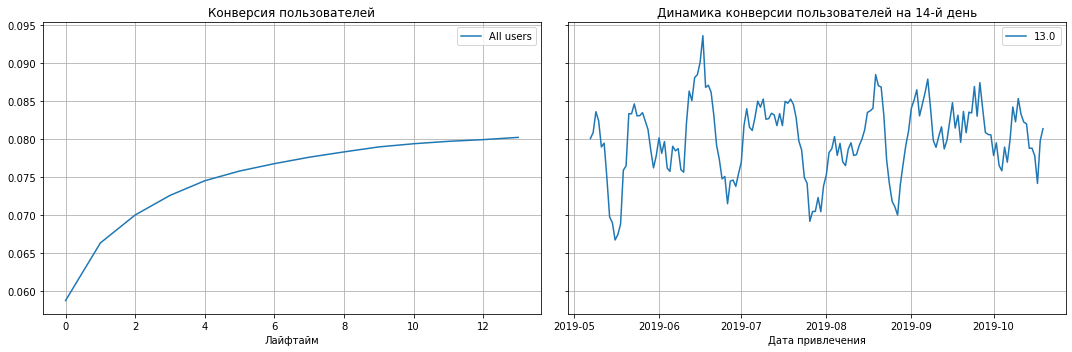

In [54]:
#Создадим таблицы с конверсией и ее динамиков с помощью функции, объявленной в начале ноутбука:

conversion_raw, conversion, conversion_history = get_conversion(profiles[profiles['channel'] != 'organic'],
    orders,
    observation_date,
    horizon_days,
    dimensions=[],
    ignore_horizon=False,
)

# Построим их графики:
plot_conversion(conversion, conversion_history, 14)

Коверсия на 14 день жизненного цикла клиента около 8%, в целом, вид графика похож на правду - постепенно возрастает, нет значений больше 1.

Посмотрим на коверсию по доп.параметрам и начнем с устройств:

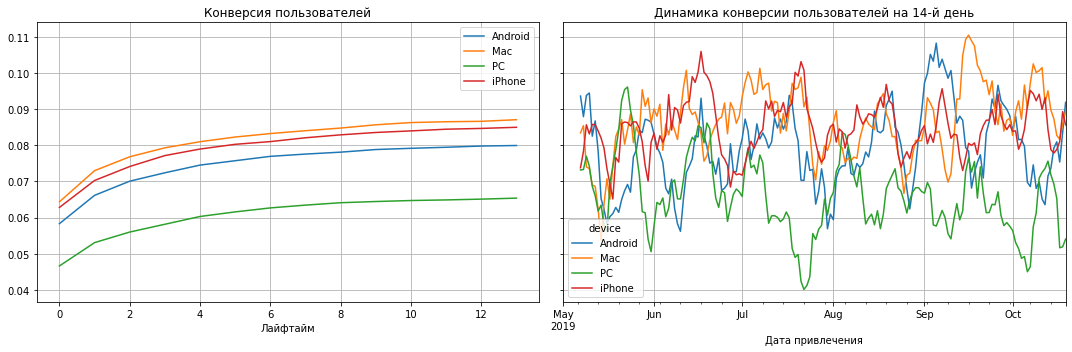

In [55]:
# Применяем функцию с доп.параметром device:
conversion_raw_dv, conversion_dv, conversion_history_dv = get_conversion(
    profiles[profiles['channel'] != 'organic'],
    orders,
    observation_date,
    horizon_days,
    dimensions=['device'],
    ignore_horizon=False,
)

# Построим их графики:
plot_conversion(conversion_dv, conversion_history_dv, 14)

Товарищи с РС конвертируются похуже, но в среднем здесь ситуация обратная с удержанием. Получается, обладатели PC/Android склонны возвращаться больше, чем пользователи iOS, а пользователи iOS более решительны на действие.
<a id='convertion_reg'></a>
Посмотрим по странам:

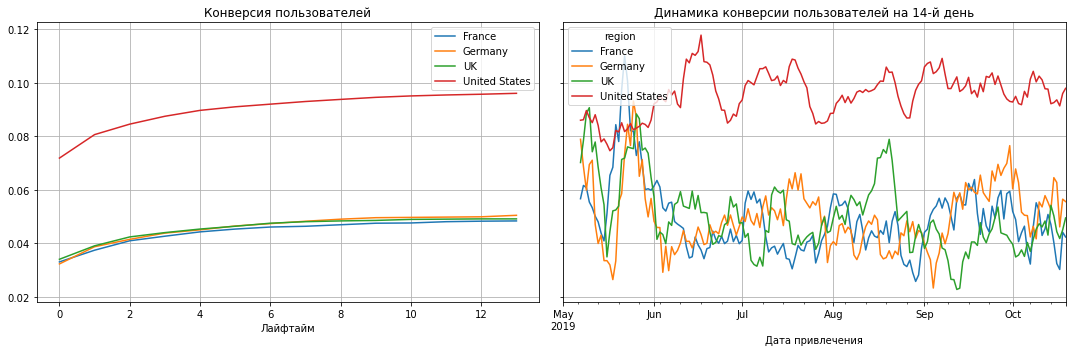

In [56]:
# Применяем функцию с доп.параметром region:
conversion_raw_rg, conversion_rg, conversion_history_rg = get_conversion(
    profiles[profiles['channel'] != 'organic'],
    orders,
    observation_date,
    horizon_days,
    dimensions=['region'],
    ignore_horizon=False,
)

# Построим графики:
plot_conversion(conversion_rg, conversion_history_rg, 14)

Здесь наблюдается такая же картина: США отстают в удержании, но в конверсии они впереди всех - решительные люди :) И неудержимые.

И каналы:

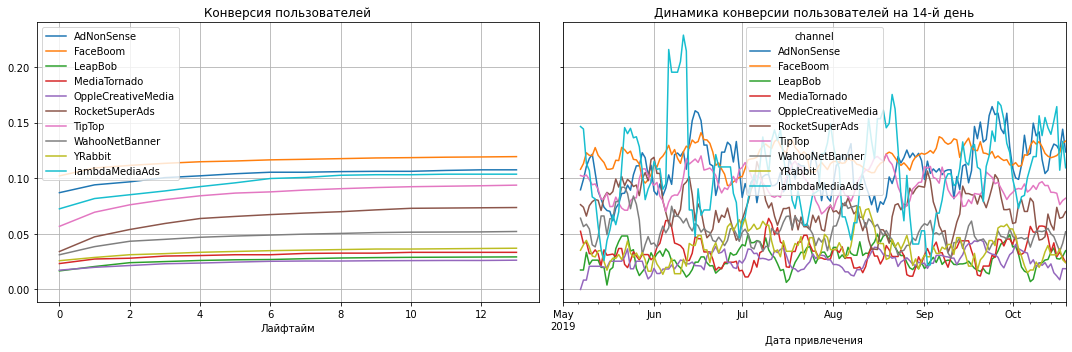

In [57]:
# Применяем функцию с доп.параметром region:
conversion_raw_ch, conversion_ch, conversion_history_ch = get_conversion(
    profiles[profiles['channel'] != 'organic'],
    orders,
    observation_date,
    horizon_days,
    dimensions=['channel'],
    ignore_horizon=False,
)

# Построим графики:
plot_conversion(conversion_ch, conversion_history_ch, 14)

С конверсией по каналам: выше всего у FaceBoom, за ним AdNonSence - каналы с плохим ROI, lambdaMediaAds имеет более круглую дугу и к концу 14ого дня почти догоняет AdNonSence. TipTop снова где-то посередине.

#### Подведем итоги:
- Реклама в целом не окупается. Но это пока.
- Из графиков видно, что реклама на каналах FaceBoom, TipTop и AdNonSence - дорогая и не окупается, из-за чего страдает общий показатель. К тому же удержание с FaceBoom и AdNonSence хуже по сравнению с остальными каналами, значит, реклама привлекает не тех пользователей. Возможно, они сначала загораются и покупают продукт, но уже не возвращаются. TipTop в этом плане получше будет, но очень уж дорогой и постоянно повышает цены. Следует учитывать, что это все происходит с пользователми из США, которых большинство.

<a id='conclus'></a>
### Общие выводы:

**С продуктовой стороны**
Что плохо:
- [средний чек](#avh_cheque) не растет (он составляет примерно 5.4 уе), 
- [количество покупок](#avh_sell_count) не увеличивается (1 в день/неделю и 2 в месяц с реднем на пользователя).

В целом, можно отметить стагнацию в развитии приложения, но вместе с тем можно отметить и позитивные моменты:
- пользователи совсем [не против посидеть](#timing) в нашем приложении (медианной время около 20мин) и 
- вполне активно [привлекаются](#activity) - идет большой прирост новых юзеров;
- пользователи быстро [принимают решение](#decision) о покупке (если заинтересовываются, быстро покупают не думая ни минуты, ну 2 минуты). 

Последний момент стоит обдумать в той точки зрения, если продукт слишком доступен по цене, его могут быстро купить, но потом просто забросить и забыть о нем. Мне думается, так и происходит со многими пользователями.

**С маркетинговой стороны**

На рекламу в общем было [затрачено](#adv_cost) 105 497.3 уе, а [средняя цена](#avh_adv_cost) на всех пользователей 0.7, если считать без органики, то 1.1.

**Основные показатели**

- В общем [реклама не окупается](#cac_channel),
- три крупных [рекламных источника](#cac_channel) сильно не дотягивают до окупаемости: TipTop, FaceBoom и AdNonSence. Из-за них проседает метрика в целом. TipTop еще и постоянно повышает цены на рекламу.
- FaceBoom и AdNonSence так же показывают очень маленькое [удержание](#retantion_chan) по сравнению с другими источниками;
- Жители США не славятся [удержанием](#retantion_reg), зато успешно [конвертируются](#convertion_reg),
- Пользователи из США [не окупаются](#usa_cac) в рекламных кампаниях.

__________

Таким образом, можно перекинуть трафик рекламы на другие каналы для США, отказаться от услуг FaceBoom, TipTop и AdNonSence: рассмотреть уже существующие и/или поискать новые. Можно попробовать договориться с TipTop о скидке - они не плохая площадка, но очень дорогие.

Еще бы посмотрела, что за реклама размещена на FaceBoom и AdNonSence - вероятно, она хорошо завлекает, но не тех пользователей, которые вернутся (в дополнение к выводу с продуктовой стороны). Особенно это видно по паре США-FaceBoom, так как в США самая популярная площадка как раз FaceBoom и пользователи из этой страны как раз с хорошей канверсией, но плохим удержанием.